<a href="https://colab.research.google.com/github/nkurinsky/THz-FTS/blob/master/python/Notebooks/DataAna/FTS_Analysis_DecemberPowerSupply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [495]:
from pylab import *
from scipy import fft
import matplotlib.pyplot as plt
from scipy.signal import periodogram as psd
from scipy.signal import get_window
import numpy as np
from scipy.signal import find_peaks
from math import sqrt, sin
from cmath import pi
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%matplotlib inline

In [496]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [497]:
import sys
sys.path.append('/content/drive/My Drive/BREAD Experiment/FTS Modeling/lib/')
from BlackbodyFunctions import *
from FTSFunctions import *

Motorized stage details (https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=2163): 


*   Max Velocity = 2.6 mm/s
*   Max Travel Range = 12mm (12e3 µm)
*   Minimum Step Size = 0.10 µm

Review this document for understanding of how FTS works/ data looks: https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Fundamentals_of_Spectroscopy/The_Power_of_the_Fourier_Transform_for_Spectroscopists

In [498]:
#define some useful constants
c_micron_per_second = 3e8 * 1e6
Hz_to_THz = 1e-12
mm_to_micron = 1000
nm_to_micron = 1/1000

noise_to_signal_ratio = 1e-7

In [499]:
#fixed variables that we can use for generating the background blackbody signal
lambda_or_nu = False
min_frequency = 0.1 #THz
max_frequency = 1500 #THz
frequency_slice_size = 0.01  #THz 
frequencies = arange(frequency_slice_size, max_frequency, frequency_slice_size) #still in THz (use min as frequency slice size)

In [500]:
############Extract the temperature as a function of voltage information to input most accurate data into the blackbody simulation##########
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'
Si253_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual.csv")
Si253_temp_manual_1 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_1.csv")
Si253_temp_manual_2 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_2.csv")
Si253_temp_manual_3 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_3.csv")
cleanedTempList = [x for x in Si253_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si253_temp_manual['Voltage'] if str(x) != 'nan']
cleanedTempList = cleanedTempList[10:] #trim off the first 10 entries from this list because it started at 0.1 V rather than 1.1 V
cleanedVoltList = cleanedVoltList[10:] 
cleanedTempList_short_1 = [x for x in Si253_temp_manual_1['Temp'] if str(x) != 'nan']
cleanedTempList_short_2 = [x for x in Si253_temp_manual_2['Temp'] if str(x) != 'nan']
cleanedTempList_short_3 = [x for x in Si253_temp_manual_3['Temp'] if str(x) != 'nan']
cleanedVoltList_short = [x for x in Si253_temp_manual_1['Voltage'] if str(x) != 'nan']
cleanedTempList_short_0_extrapolate = interp1d(cleanedVoltList, cleanedTempList, fill_value='extrapolate')
cleanedTempList_short_1_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_1, fill_value='extrapolate')
cleanedTempList_short_2_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_2, fill_value='extrapolate')
cleanedTempList_short_3_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_3, fill_value='extrapolate')

def get_temp(volt, manual = False):
  if manual:
    #this returns the manually calculated temperautre value from data taken with thermal camera
    average_temp = (cleanedTempList_short_0_extrapolate(volt) + cleanedTempList_short_1_extrapolate(volt) + cleanedTempList_short_2_extrapolate(volt) + cleanedTempList_short_3_extrapolate(volt))/4
    return (average_temp)
  else: 
    # from the IR-Si253 voltage temperature plot (https://www.boselec.com/wp-content/uploads/Linear/IRSources/IRSourcesLiterature/IR-Si253-Series-formerly-IR-18-and-IR-19.pdf), were able to extract data points and fit to a polynomial using excel. 
    # The equation seen here is the corresponding relationship between voltage (V) and temperature (K)
    # Note that these values are no longer valid after the "plateu" that is seen becasue of the max current in the UPS
    t =  -3.5727 * volt**2 + 136.61*volt + 294.53
    return t

In [501]:
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/Autumn2020Data_NewPowerSupply/'
list_of_files = [
  'data/20nov2020-1500PMthru1600PM-Thorlabs-Laser-635nm-472THz-noFilter-50nmPerSeconds100micronTravel.csv',
  'data/20nov2020-1423PMthru1435PM-Thorlabs-Laser-635nm-472THz-noFilter-50nmPerSeconds50micronTravel.csv',
  'data/20nov2020-1123AMthru1135AM-Thorlabs-Laser-635nm-472THz-noFilter-100nmPerSeconds70micronTravel.csv',
  'data/20nov2020-1111AMthru1125AM-Thorlabs-Laser-635nm-472THz-noFilter-100nmPerSeconds50micronTravel.csv',
  'data/24nov2020-1108AMthru1150PM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1200PMthru1242PM-IR-Si253-7p6V-1p39A-plasticBagFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1245PMthru1328PM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1332PMthru1415PM-IR-Si253-7p6V-1p39A-PEWFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1420PMthru1502PM-IR-Si253-7p6V-1p39A-SiWFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1508PMthru1551PM-IR-Si253-7p6V-1p39A-1650nmFilter-100nmPerSeconds250micronTravel.csv',
  'data/25nov2020-0939AMthru1104AM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds500micronTravel.csv',
  'data/25nov2020-1116AMthru1241PM-IR-Si253-7p6V-1p39A-plasticBagFilter-100nmPerSeconds500micronTravel.csv',
  'data/30nov2020-1026AMthru1225PM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds700micronTravel.csv', 
  'data/30nov2020-1229PMthru1427PM-IR-Si253-7p6V-1p39A-plasticBagFilter-100nmPerSeconds700micronTravel.csv',
  'data/30nov2020-1431PMthru1630PM-IR-Si253-7p6V-1p39A-PEWFilter-100nmPerSeconds700micronTravel.csv',
  'data/30nov2020-1636PMthru1835PM-IR-Si253-7p6V-1p39A-SiWFilter-100nmPerSeconds700micronTravel.csv',
  'data/01dec2020-0912AMthru1111AM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds700micronTravel.csv',
  'data/01dec2020-1151AMthru1350PM-IR-Si253-7p6V-1p39A-25micronMeshFilter-100nmPerSeconds700micronTravel.csv',
  'data/01dec2020-1409PMthru1608PM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds700micronTravel.csv',
  'data/02dec2020-0820AMthru1019AM-IR-Si253-7p6V-1p39A-DoublePlasticBagFilter-100nmPerSeconds700micronTravel.csv',
  'data/02dec2020-1049AMthru1248PM-IR-Si253-9p5V-1p46A-noFilter-100nmPerSeconds700micronTravel.csv',
  'data/02dec2020-1254PMthru1453PM-IR-Si253-9p5V-1p46A-plasticBagFilter-100nmPerSeconds700micronTravel.csv',
  'data/04dec2020-0954AMthru1045AM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds1500micronTravel.csv',
  'data/04dec2020-1048AMthru1144AM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds1700micronTravel.csv',
  'data/04dec2020-1148AMthru1244PM-IR-Si253-9p5V-1p46A-SiWFilter-500nmPerSeconds1700micronTravel.csv',
  'data/04dec2020-1248PMthru1441PM-IR-Si253-9p5V-1p46A-SiWFilter-250nmPerSeconds1700micronTravel.csv',
  'data/04dec2020-1446PMthru1639PM-IR-Si253-9p5V-1p46A-PEWFilter-250nmPerSeconds1700micronTravel.csv',
  'data/07dec2020-0952AMthru1132AM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds3000micronTravel.csv',
  'data/07dec2020-1140AMthru1325PM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds3000micronTravel.csv',
  'data/07dec2020-1322PMthru1510PM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds3000micronTravel.csv',
  'data/07dec2020-1507PMthru1710PM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds4000micronTravel.csv',
  'data/08dec2020-1020AMthru1200PM-IR-Si253-9p5V-1p46A-DoublePlasticBagFilter-500nmPerSeconds3000micronTravel.csv',
  'data/08dec2020-1203PMthru1343PM-IR-Si253-9p5V-1p46A-SiWFilter-500nmPerSeconds3000micronTravel.csv',
  'data/08dec2020-1346PMthru1559PM-IR-Si253-9p5V-1p46A-SiWFilter-500nmPerSeconds4000micronTravel.csv',
  'data/09dec2020-0917AMthru1042AM-IR-Si253-10p4V-1p50A-1000nmBandpassFilter-100nmPerSeconds270micronTravel.csv',
  'data/09dec2020-1048AMthru1131AM-IR-Si253-10p6V-1p50A-1000nmBandpassFilter-100nmPerSeconds252p94micronTravel.csv',
  'data/09dec2020-1143AMthru1315PM-IR-Si253-10p6V-1p50A-1650nmBandpassFilter-100nmPerSeconds500micronTravel.csv',
  'data/09dec2020-1311PMthru1435PM-IR-Si253-10p6V-1p50A-1650nmBandpassFilter-100nmPerSeconds500micronTravel.csv', 
  'data/09dec2020-1439PMthru1525PM-IR-Si253-10p6V-1p50A-1000nmBandpassFilter-100nmPerSeconds270micronTravel.csv',
  'data/14dec2020-1029AMthru1228PM-IR-Si253-10p6V-1p50A-noFilter-100nmPerSeconds700micronTravel.csv',
  'data/14dec2020-1254PMthru1453PM-IR-Si253-7p6V-1p39A-OfficeDepotRuledPaperFilter-100nmPerSeconds700micronTravel.csv',
  'data/14dec2020-1456PMthru1655PM-IR-Si253-7p6V-1p39A-OfficeDepotRuledPaperFilter-100nmPerSeconds700micronTravel.csv',
  'data/15dec2020-1010AMthru1209PM-IR-Si253-7p6V-1p39A-OfficeDepotRuledPaperFilter-100nmPerSeconds700micronTravel.csv',
  'data/15dec2020-1242PMthru1441PM-IR-Si253-10p6V-1p50A-OfficeDepotRuledPaperFilter-100nmPerSeconds700micronTravel.csv',
  'data/15dec2020-1446PMthru1645PM-IR-Si253-10p6V-1p50A-PEWandSiWFilter-100nmPerSeconds700micronTravel.csv'
  ]

In [502]:
## extract information from file according to name:
def get_file_parameters(f):  
  #print('Processing {0}'.format(f))

  # Read in CSV file
  df = pd.read_csv(folder_path + f, header=None, usecols=[0,1])

  # Make legend name from file name
  fi = f.split('-')
  source = fi[3]

  if source == "Laser": voltage, current = 0, 0
  else:
    voltage = float(fi[4].replace('p', '.').replace('V', ''))
    current = fi[5].replace('p', '.')
  motion  = fi[7].replace('nmPerSeconds', ' nm/s, ').replace('p', '.').replace('.csv', '')
  source = fi[3]
  filter  = fi[6]
  date = fi[0].replace('data/', '')
  time = fi[1]
  source = '{0}-{1}'.format(fi[2], fi[3])

  if filter == "1650nmFilter": filter = "1650nmBandpassFilter" # fix small error in one filter naming process! 
  case = '{0}_{1}: {2} {3} ({4}V, {5}, {6}) '.format(date, time, source, filter, str(voltage), current,  motion)

  mirrorVelocity = fi[7].split('nm')[0]
  timeToSpace = float(mirrorVelocity) / 1000 # convert seconds to mirror displacement (100 nm / s)

  c  = 3 * (10 ** 17)  # Speed of light in nm / s
  Rs = 5               # Detector sampling rate
  vm = float(mirrorVelocity) # Mirror velocity in nm / s (extract from file name)

  fs = (c * Rs ) / (2 * vm * 10 ** 12) # Sampling frequency in THz (factor of 2 is twice path length)

  x = df[0] * timeToSpace
  y = df[1]

  runparameters = [source, voltage, current, filter, motion, date, time, vm]
  return x, y, runparameters, case

In [503]:
all_data  = {}

for f in list_of_files:
  x, y, runparameters, case = get_file_parameters(f)
  all_data.update({case:[x,y,runparameters]})
  print(case)

20nov2020_1500PMthru1600PM: Thorlabs-Laser noFilter (0V, 0, 50 nm/s, 100micronTravel) 
20nov2020_1423PMthru1435PM: Thorlabs-Laser noFilter (0V, 0, 50 nm/s, 50micronTravel) 
20nov2020_1123AMthru1135AM: Thorlabs-Laser noFilter (0V, 0, 100 nm/s, 70micronTravel) 
20nov2020_1111AMthru1125AM: Thorlabs-Laser noFilter (0V, 0, 100 nm/s, 50micronTravel) 
24nov2020_1108AMthru1150PM: IR-Si253 noFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1200PMthru1242PM: IR-Si253 plasticBagFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1245PMthru1328PM: IR-Si253 noFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1332PMthru1415PM: IR-Si253 PEWFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1420PMthru1502PM: IR-Si253 SiWFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1508PMthru1551PM: IR-Si253 1650nmBandpassFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
25nov2020_0939AMthru1104AM: IR-Si253 noFilter (7.6V, 1.39A, 100 nm/s, 500micronTravel) 
25nov2020_1116A

In [504]:
def generate_simulation(selected_volt, source, filt, scale_weight = 5e-3, add_weight = 1e-4, for_transmittance=False):
  temp = get_temp(selected_volt)
  filter_check = filt + "Filter"
  filter_val = 0

  if for_transmittance:
    Ls = []
    for key in all_data:
      if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3] in filter_check: Ls.append(max(all_data[key][0])) #exctract the length traveled of the first function that has the right voltage and source
    L = max(Ls) 
    dx = -1*L/2
    x, y, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="no", dx=dx, L=L, dL=dL,  Temp=temp )

  else:
    Ls = []
    for key in all_data:
      if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3] in filter_check: Ls.append(max(all_data[key][0])) #exctract the length traveled of the first function that has the right voltage and source
    L = max(Ls)
    dx = -1*L/2
    if filt == "PEW" or filt =="SiW": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter=filt, dx=dx, L=L, dL=dL,  Temp=temp )
    elif filt == "1650nmBandpass": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="narrow_1650", dx=dx, L=L, dL=dL,  Temp=temp )
    elif filt == "1000nmBandpass": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="narrow_1000", dx=dx, L=L, dL=dL,  Temp=temp )
    else: x, y, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="no", dx=dx, L=L, dL=dL,  Temp=temp )


  sigma = scale_weight*noise_to_signal_ratio
  y = scale_weight*y + np.random.rand(len(x))*sigma + add_weight
  frequency, spectrum = psd_frequency(y, 'parzen')

  return [x, y, frequency, spectrum, filter_val]

In [505]:
def plot_transmittance(frequency_array, averages, selected_volt, source, filt, simulated, scale_weight, add_weight):
  if filt == "no":  return ####### cant take a ratio if the filter of interest is no filter
  
  if filt != "PEW" and filt !="SiW" and filt != "1650nmBandpass" and filt != "1000nmBandpass": simulation = False 
  else: 
    simulation = True

    simulated_nofilt = generate_simulation(selected_volt, source, "no", for_transmittance=True)
    f_sim_nofilter, s_sim_nofilter = simulated_nofilt[2], simulated_nofilt[3]
    f_sim, s_sim, filter_val = simulated[2], simulated[3], simulated[4]

  average_spectrum_filter, num_avg_filter = averages[0][0], averages[0][1]
  average_spectrum_nofilter, num_avg_nofilter = averages[1][0], averages[1][1]
  ratio =  np.array(average_spectrum_filter)/np.array(average_spectrum_nofilter)

  fig = plt.figure(figsize=(8, 6), dpi=150) 
  if simulation:
    interpolate_sim = interp1d(f_sim, s_sim, fill_value='extrapolate')
    interpolate_sim_nofilter = interp1d(f_sim_nofilter, s_sim_nofilter, fill_value='extrapolate')
    simulation_ratio = interpolate_sim(frequency_array)/interpolate_sim_nofilter(frequency_array)
    plt.plot(frequency_array, simulation_ratio, label = "Simulated filter bandpass", color='orange')
    plt.semilogy(frequency_array, filter_val, '--', label = 'Estimated tophat filter acceptance', color='C6')
  
  plt.plot(frequency_array, ratio, label = "Filter bandpass data (averaged over " + str(num_avg_filter) + " filter trials)", color='C9')
  title = filt + " Filter Bandpass as a function of Frequency"
  plt.title(title)
  plt.legend()
  plt.xscale('log')
  plt.grid(True)
  plt.xlim(4e-1, 1100)
  plt.xlabel('Frequency (THz)')
  plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")
  return

In [506]:
def plot_details(selected_volt, source, filt, simulated):
  filter_check = filt + "Filter"
  temp = get_temp(selected_volt)
  fig = plt.figure(figsize=(23, 6), dpi=150)
  plt.subplot(1, 2, 1)

  if len(simulated) > 0: 
    plot_simulation = True
    x_simulated, y_simulated, frequency_simulated, spectrum_simulated, filter_val = simulated[0], simulated[1], simulated[2], simulated[3], simulated[4]  
    plt.plot(x_simulated, y_simulated, label = "simulated")
  else: plot_simulation = False

  for key in all_data:
    if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check: plt.plot(all_data[key][0], all_data[key][1], label = all_data[key][2][5] + "_" + all_data[key][2][6] + ": " + all_data[key][2][4])
  
  plt.subplot(1,2,2)
  if plot_simulation: plt.semilogy(frequency_simulated, spectrum_simulated, label = "transform of simulated")

  for key in all_data:
    if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check:
      if "1650nm" in key: plt.axvline(x=181.6, color = 'yellow')
      elif "1000nm" in key: plt.axvline(x=299.7, color = 'yellow')
      frequency, spectrum = psd_frequency_vm(all_data[key][1], 'parzen', vm=all_data[key][2][7])
      plt.semilogy(frequency, spectrum, label = "transform of "+ all_data[key][2][5] + ": " + all_data[key][2][4])

  #plot details for blackbody spectrum plot
  plt.subplot(1, 2, 1)
  plt.grid(True)
  title = source + " at " + str(selected_volt) + "V (" + str(int(temp)) + "K) Interferometer Signal with " + filt + " filter"
  plt.title(title)
  plt.legend()
  plt.yscale('log')
  plt.xlabel("Optical path difference ($\mu m$)")
  plt.ylabel("Signal Amplitude \n Corresponds to optical power ($\mu W$)")

  # #plot details for fourier transform plot 
  plt.subplot(1, 2, 2)
  plt.title("Transform as a function of Frequency")
  plt.legend()
  plt.grid(True)
  plt.xscale('log')
  plt.xlabel('Frequency (THz)')
  plt.ylabel("Power Density(W/THz)")
  plt.show()
  return 

In [507]:
def generate_average_spectrum(frequency_array, selected_volt, source, filt):
  filter_check = filt + "Filter"
  interpolated = []

  for key in all_data:
    if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check: 
      frequency, spectrum = psd_frequency_vm(all_data[key][1], 'parzen', vm=all_data[key][2][7])
      interpolated_function = interp1d(frequency, spectrum, fill_value='extrapolate')
      interpolated.append(interpolated_function(frequency_array))

  if len(interpolated) == 1: average_spectrum = interpolated[0]
  else: average_spectrum = np.average(np.vstack(np.array(interpolated)), axis=0)

  return [average_spectrum, len(interpolated)]

In [508]:
def plot_average(frequency_array, averages, selected_volt, source, filt):
  temp = get_temp(selected_volt)
  fig = plt.figure(figsize=(12, 6), dpi=100)
  
  average_spectrum_filter, num_avg_filter = averages[0][0], averages[0][1]
  if filt != "no" : 
    average_spectrum_nofilter, num_avg_nofilter = averages[1][0], averages[1][1]
    plt.semilogy(frequency_array, average_spectrum_nofilter, label = "average transform for no filter (averaged over " + str(num_avg_nofilter) + " trials)")
 
  plt.semilogy(frequency_array, average_spectrum_filter, label = "average transform for " + filt + " filter (averaged over " + str(num_avg_filter) + " trials)")
  plt.title("Fourier Transform of " + source + " at " + str(selected_volt) + "V (" + str(int(temp)) + "K) as a function of Frequency")
  plt.legend()
  plt.grid(True)
  plt.xscale('log')
  plt.xlabel('Frequency (THz)')
  plt.xlim(4e-1, 1100)
  plt.ylabel("Power Density(W/THz)") 
  plt.show()
  return 

In [509]:
def plot_data(selected_volt, source, filt, plot_simulation = True, compare_nofilter = True, bandpass = False, scale_weight = 5e-3, add_weight = 1e-4):
  simulated = []
  if plot_simulation or bandpass:  
    simulated = generate_simulation(selected_volt, source, filt, scale_weight=scale_weight, add_weight=add_weight)
    
  plot_details(selected_volt, source, filt, simulated)
  
  if bandpass or compare_nofilter:
    avgs = []    
    avgs.append(generate_average_spectrum(frequencies, selected_volt, source, filt))
    if filt != "no" : avgs.append(generate_average_spectrum(frequencies, selected_volt, source, "no"))
  if bandpass: plot_transmittance(frequencies, avgs, selected_volt, source, filt, simulated, scale_weight = 5e-3, add_weight = 1e-4)
  if compare_nofilter: plot_average(frequencies, avgs, selected_volt, source, filt)
  
  return 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


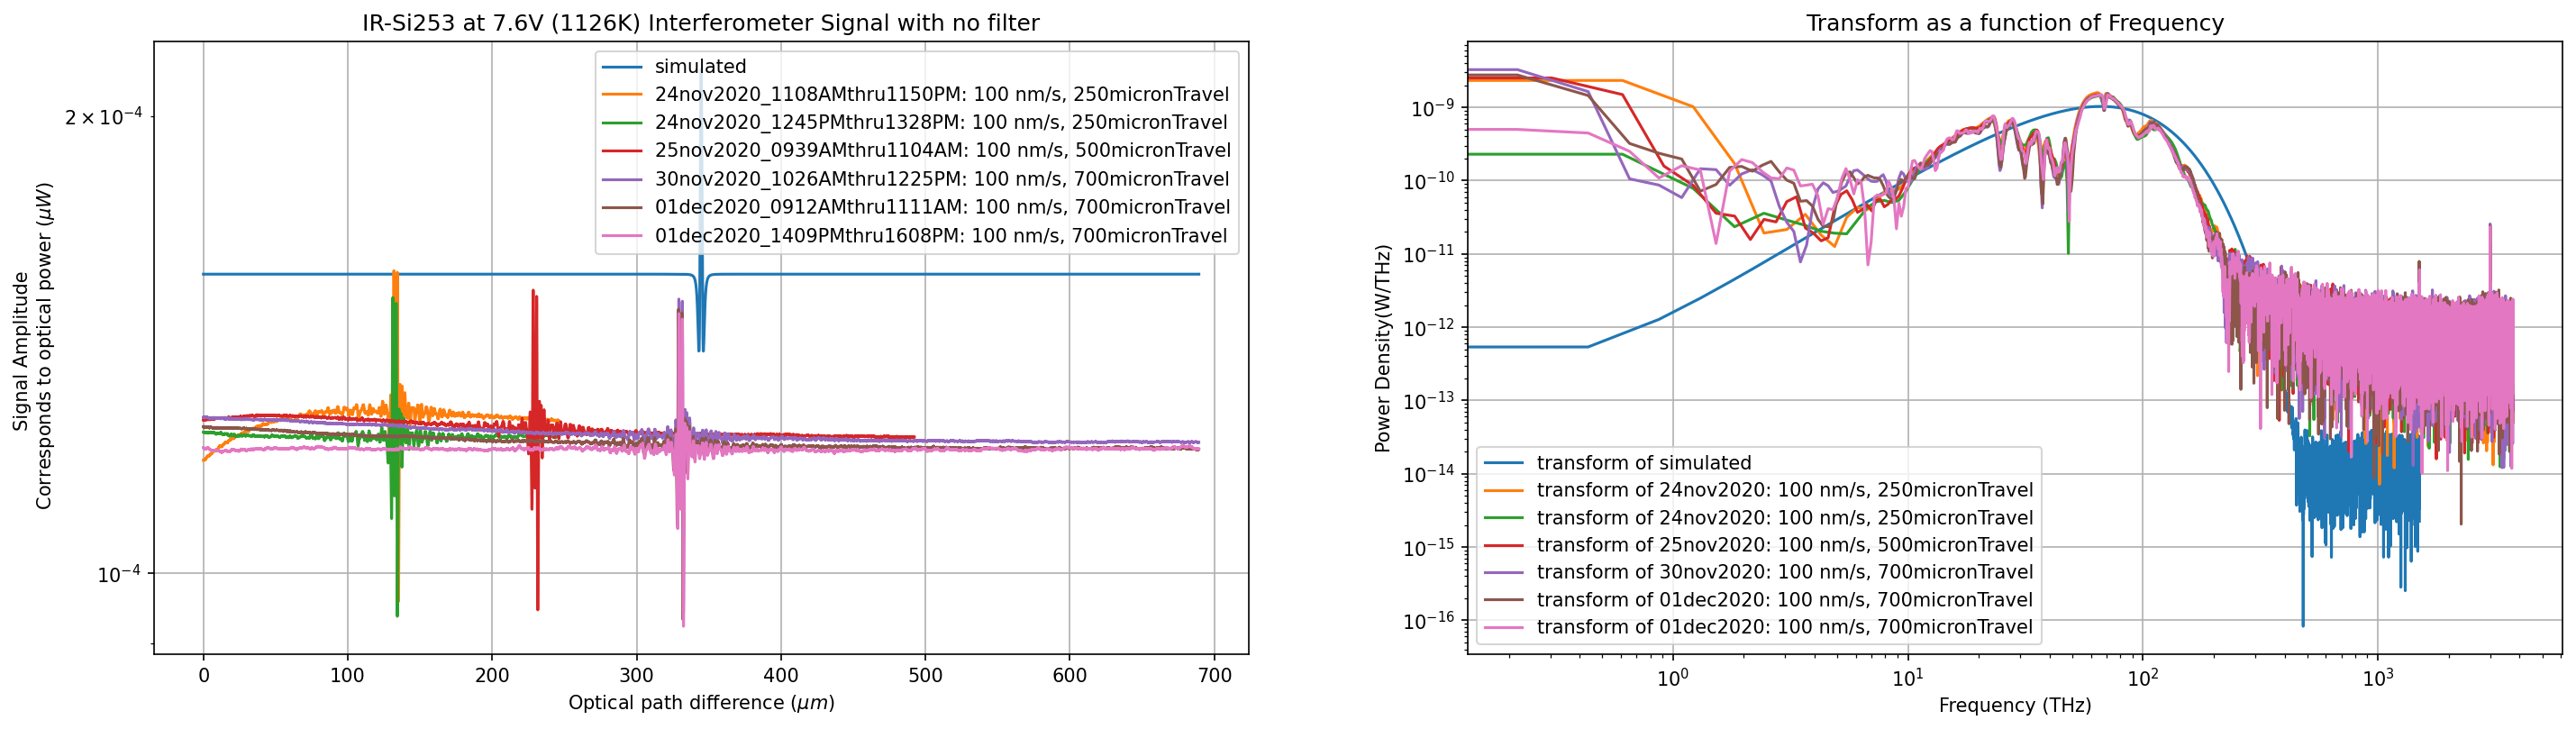

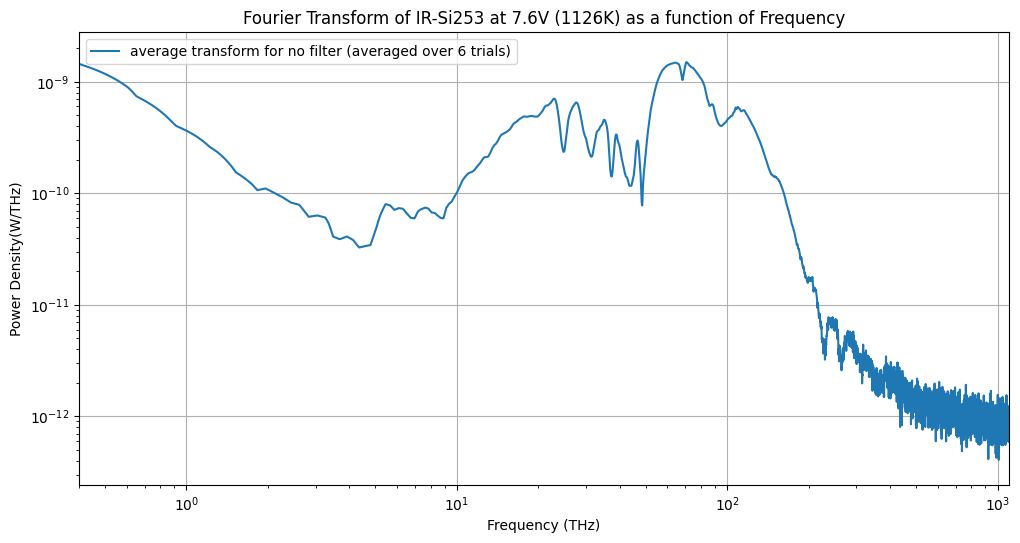

In [510]:
selected_volt = 7.6
source = "IR-Si253"
filt = "no"

plot_data(selected_volt, source, filt, plot_simulation = True, compare_nofilter = True, scale_weight = 1e-2, add_weight = 1e-4)

Plots with PEW Filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


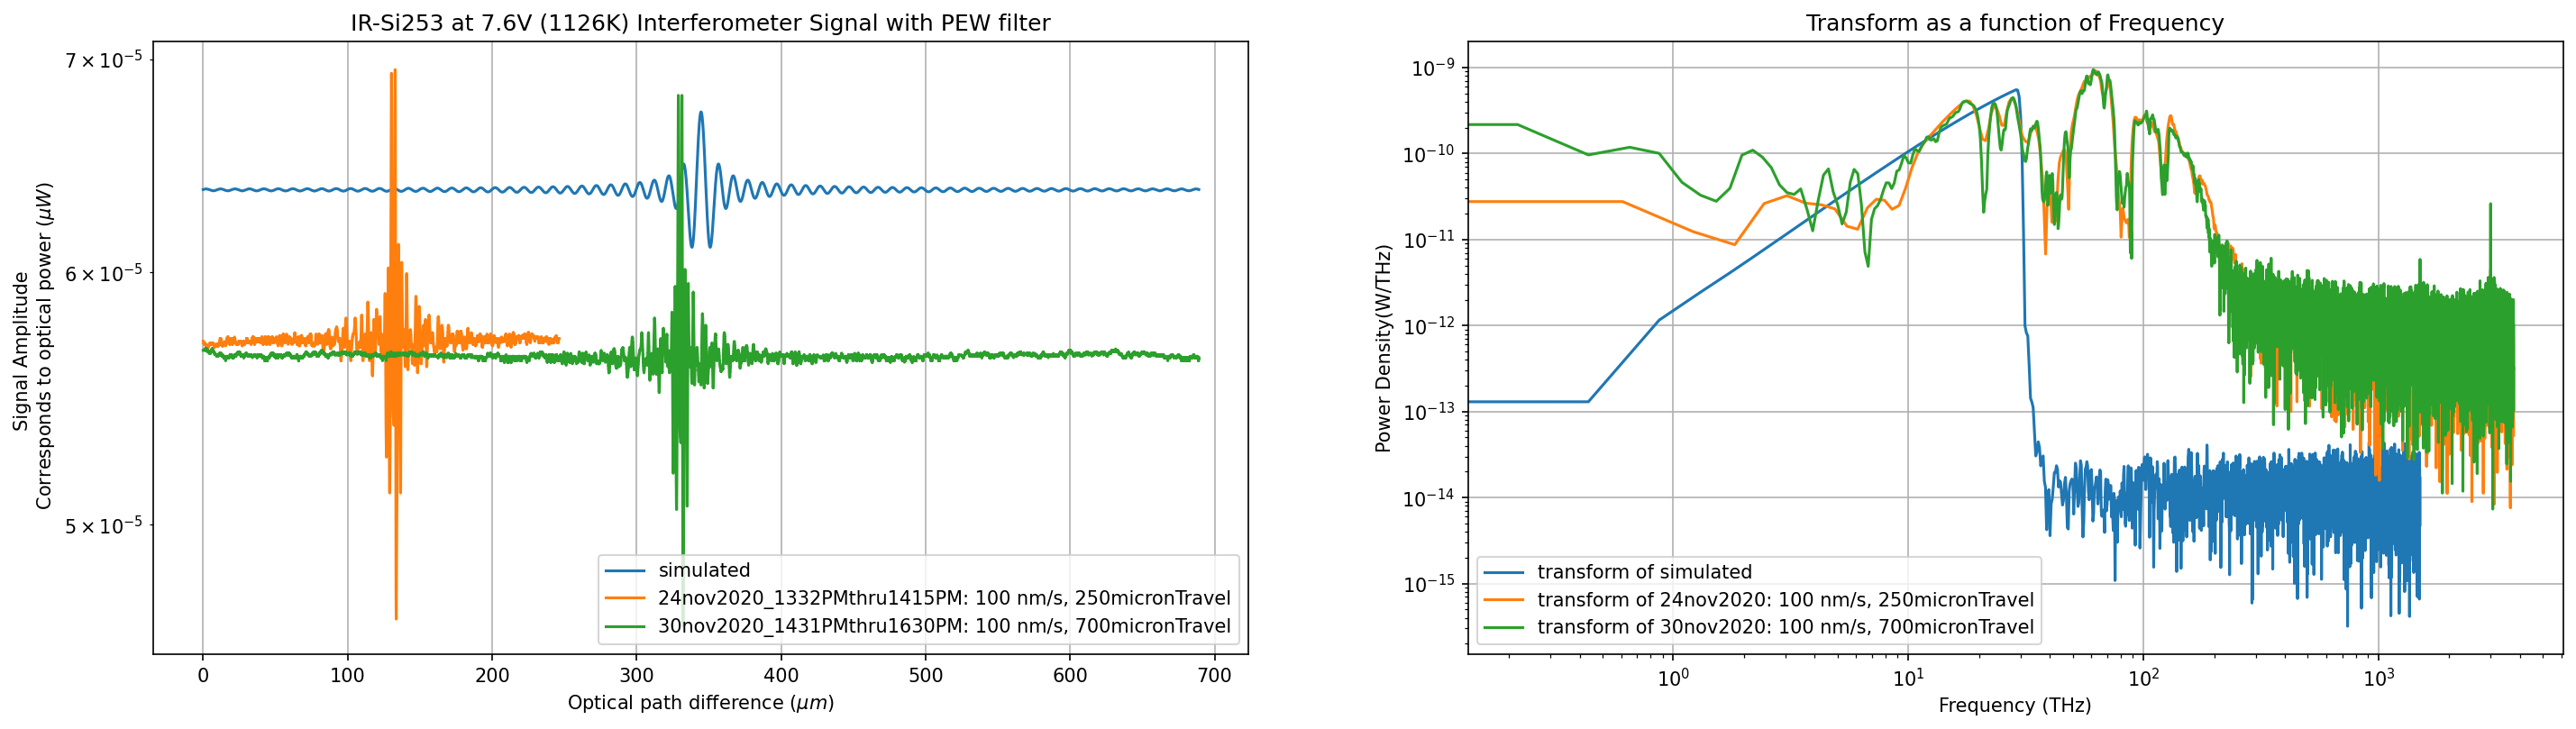

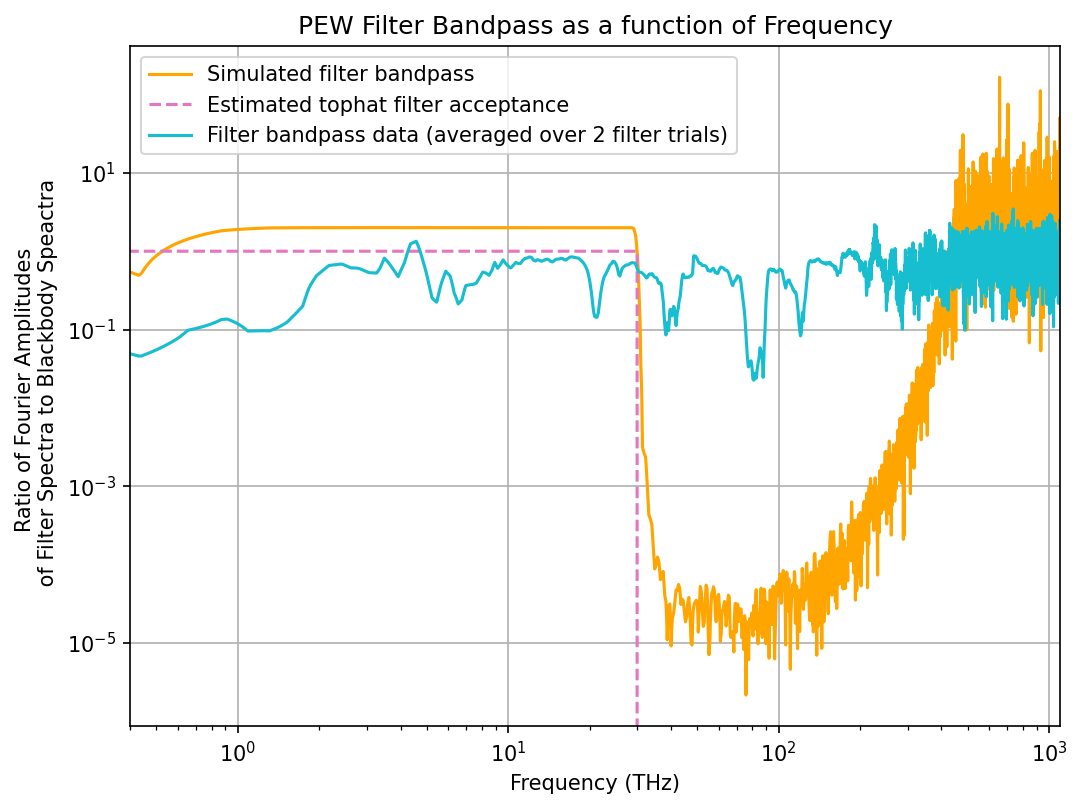

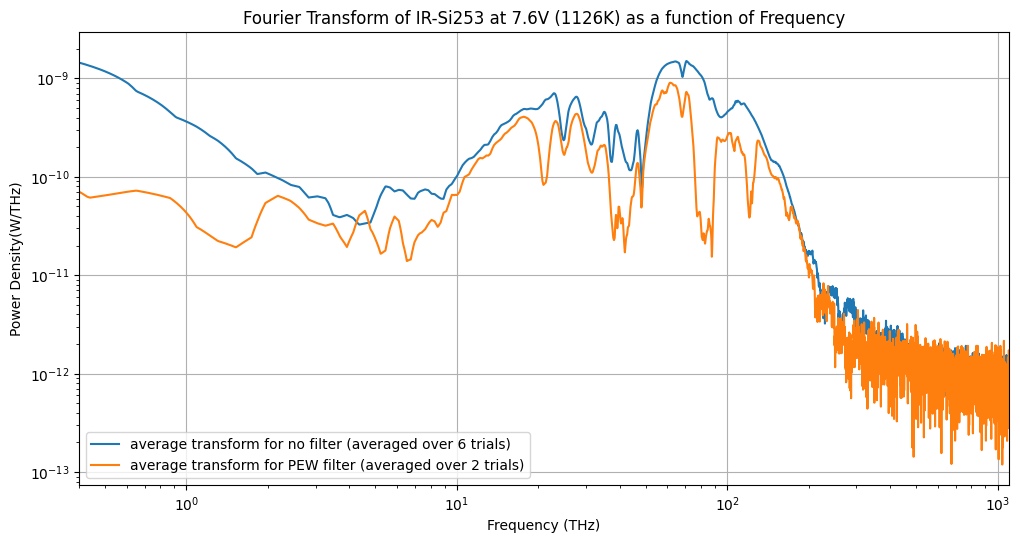

In [511]:
selected_volt = 7.6
source = "IR-Si253"
filt = "PEW"

plot_data(selected_volt, source, filt, plot_simulation = True, compare_nofilter = True, bandpass = True, scale_weight = 1e-2, add_weight = 6e-5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


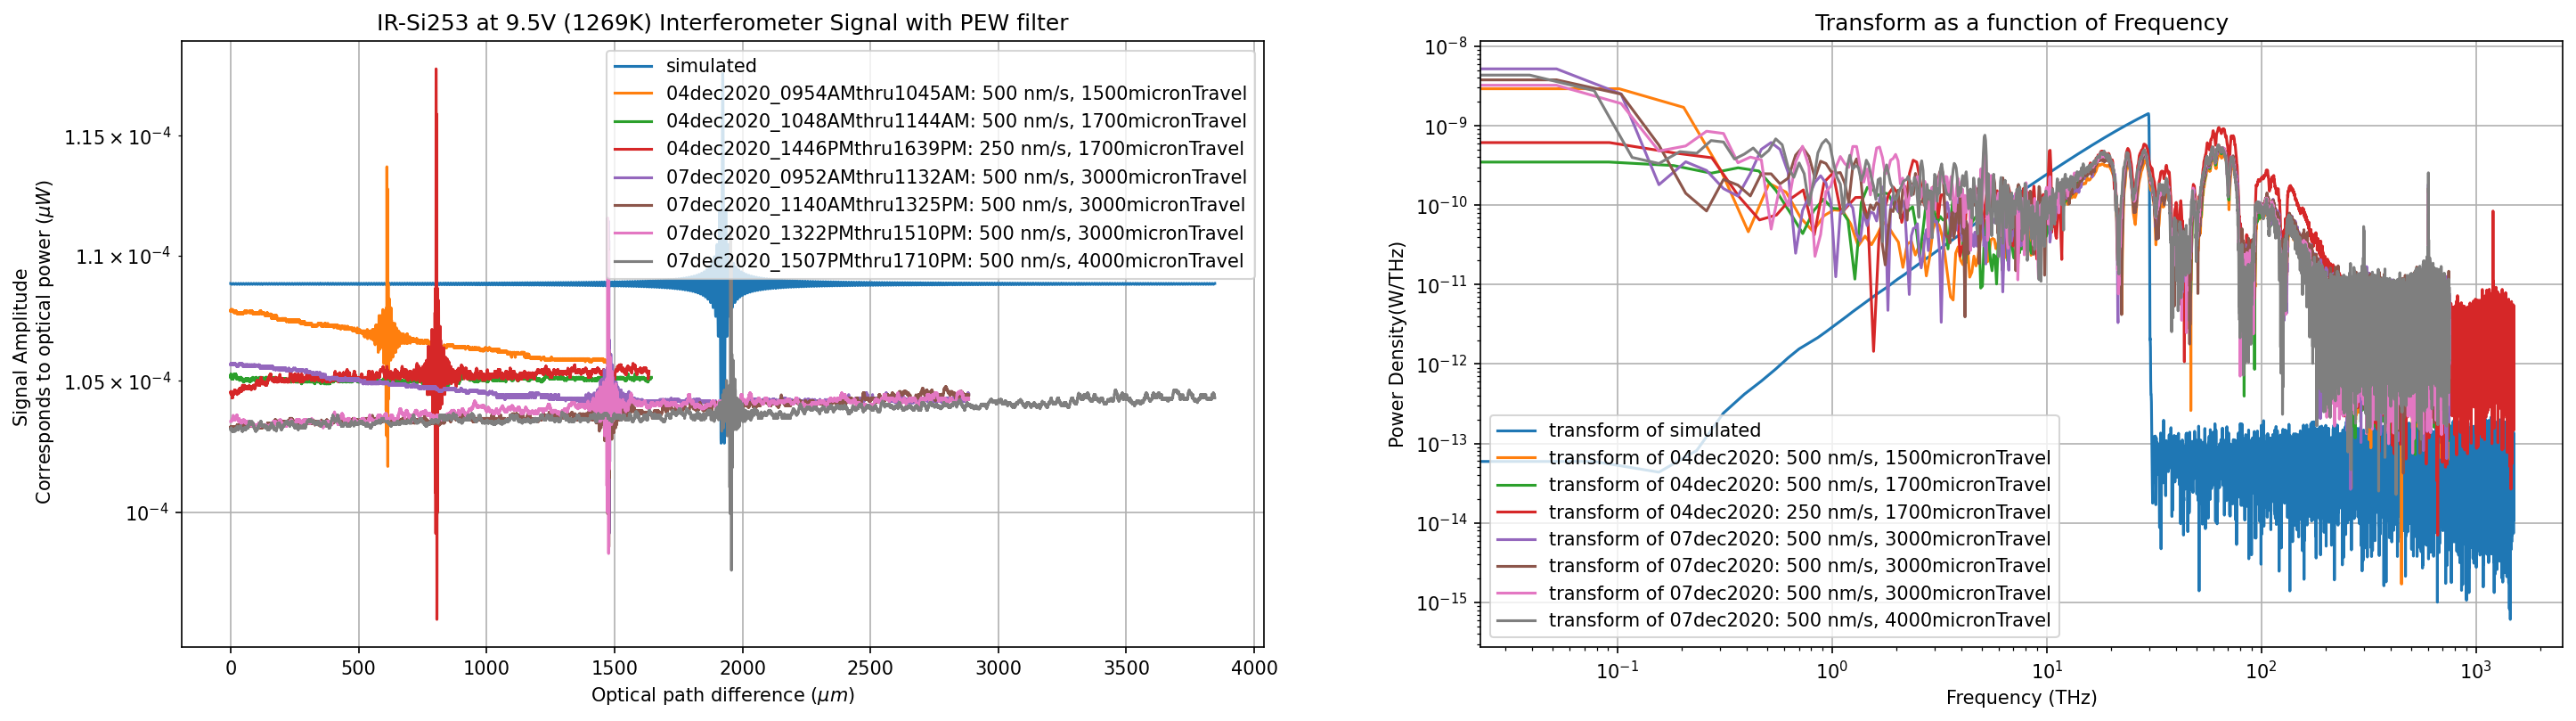

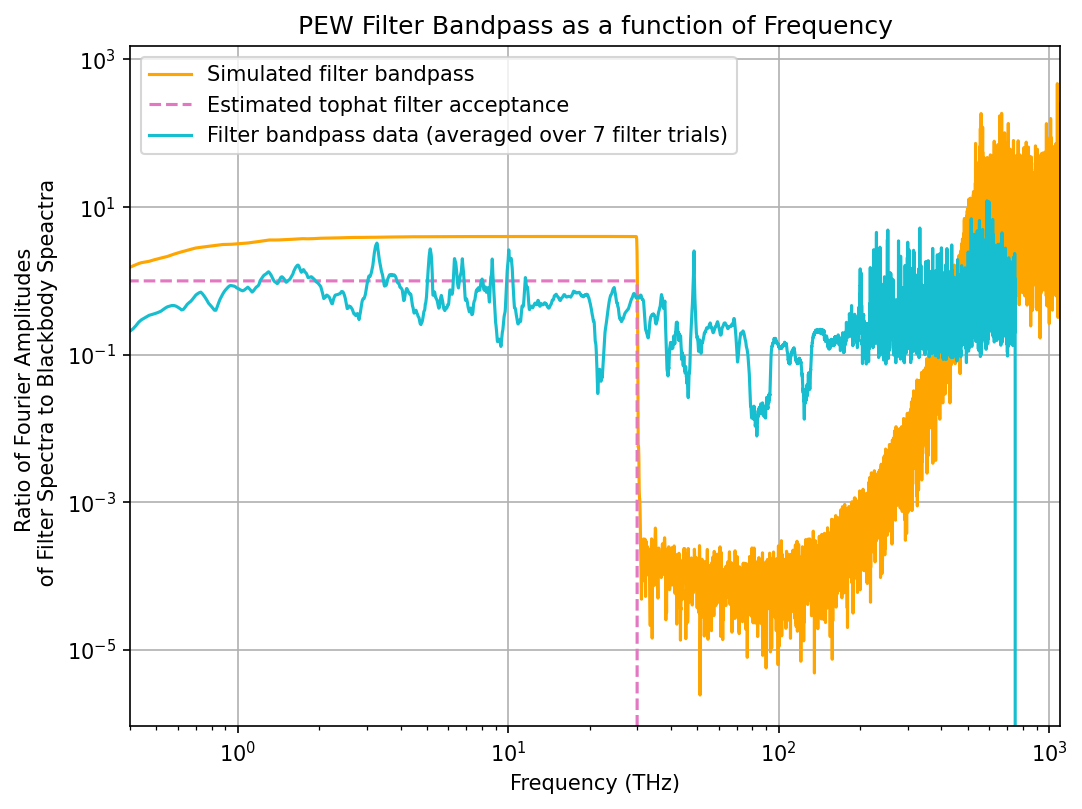

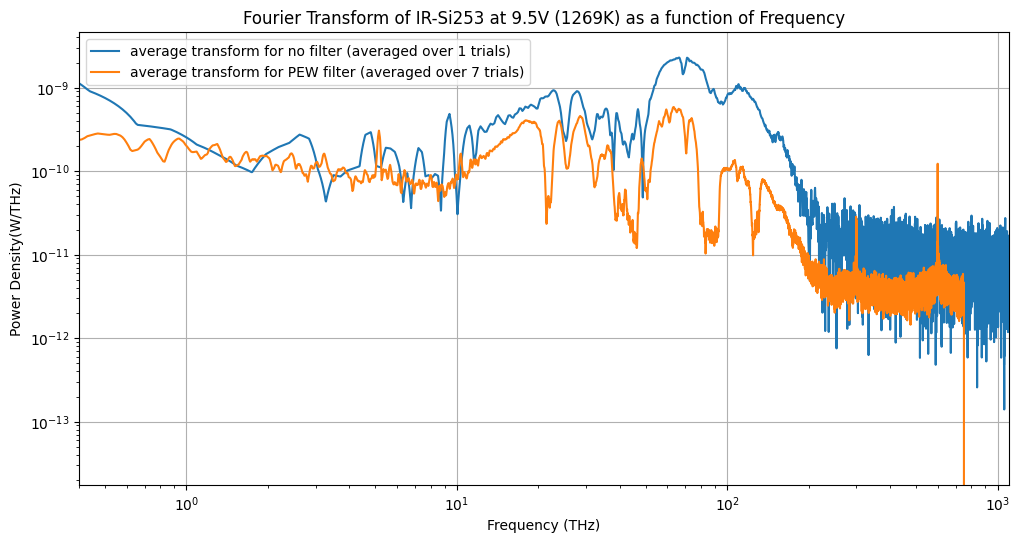

In [512]:
selected_volt = 9.5
source = "IR-Si253"
filt = "PEW"
plot_data(selected_volt, source, filt, plot_simulation = True, compare_nofilter = True, bandpass = True, scale_weight = 2e-2, add_weight = 1e-4)

Plots with SiW Filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


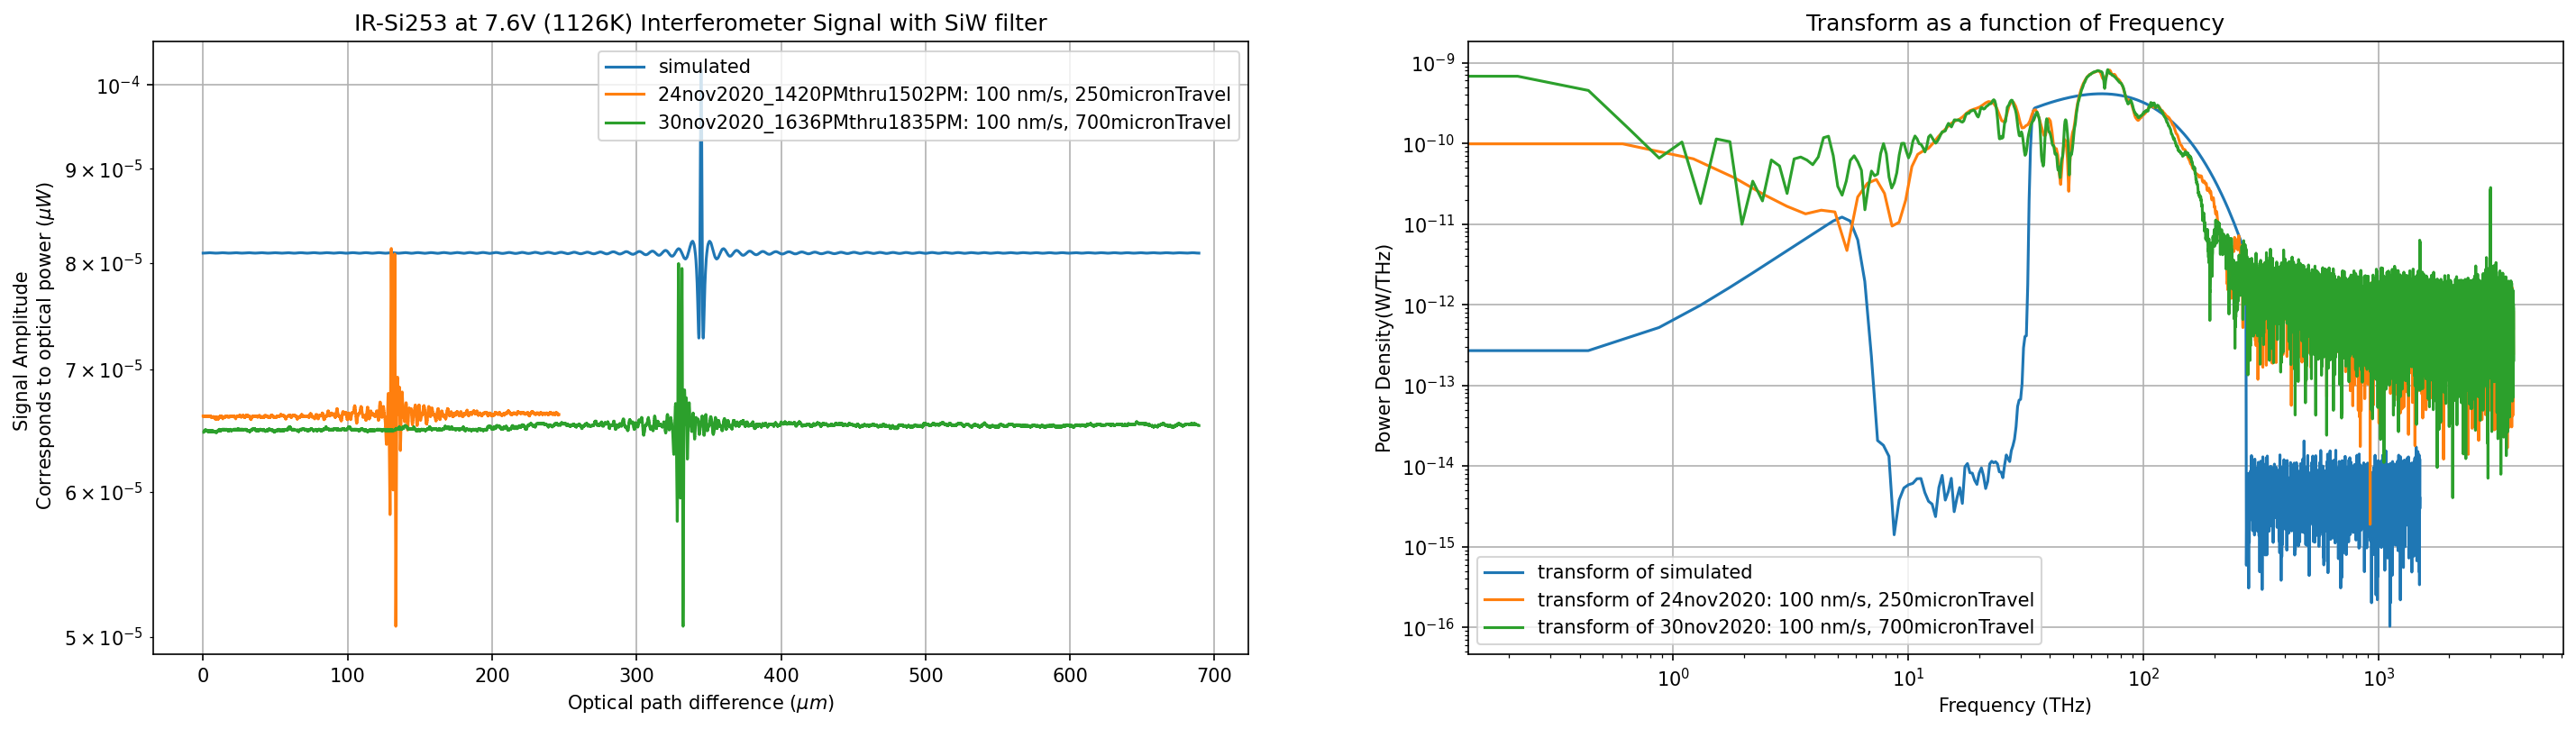

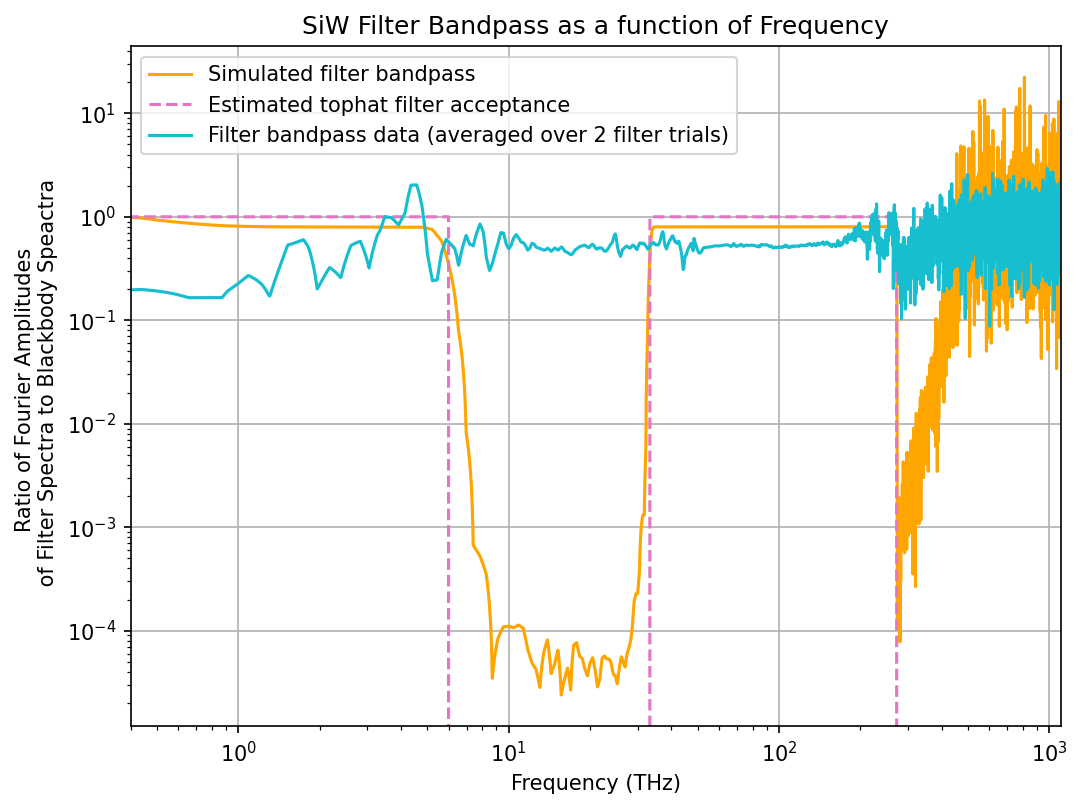

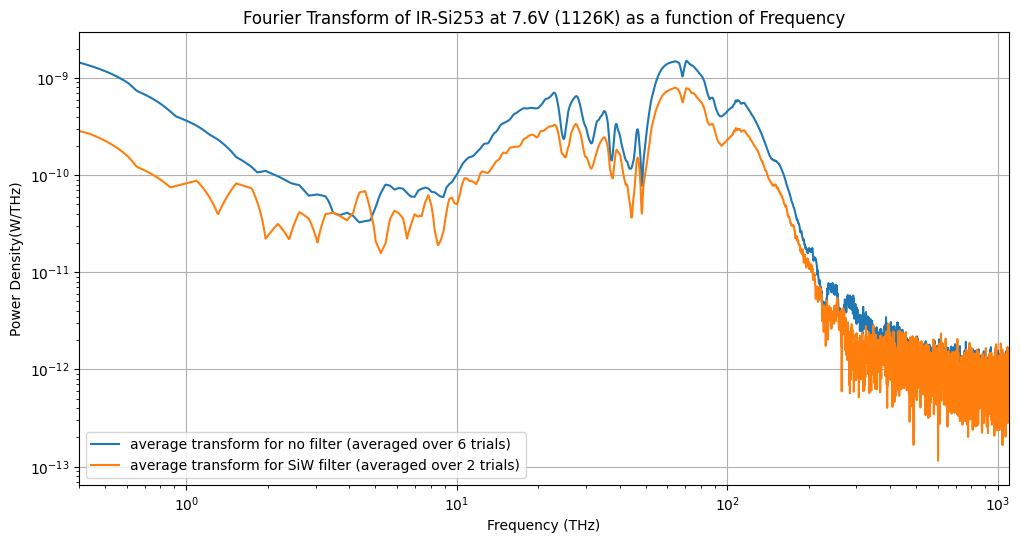

In [513]:
selected_volt = 7.6
source = "IR-Si253"
filt = "SiW"

plot_data(selected_volt, source, filt, plot_simulation = True, compare_nofilter = True, bandpass = True, scale_weight = 4e-3, add_weight = 6e-5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


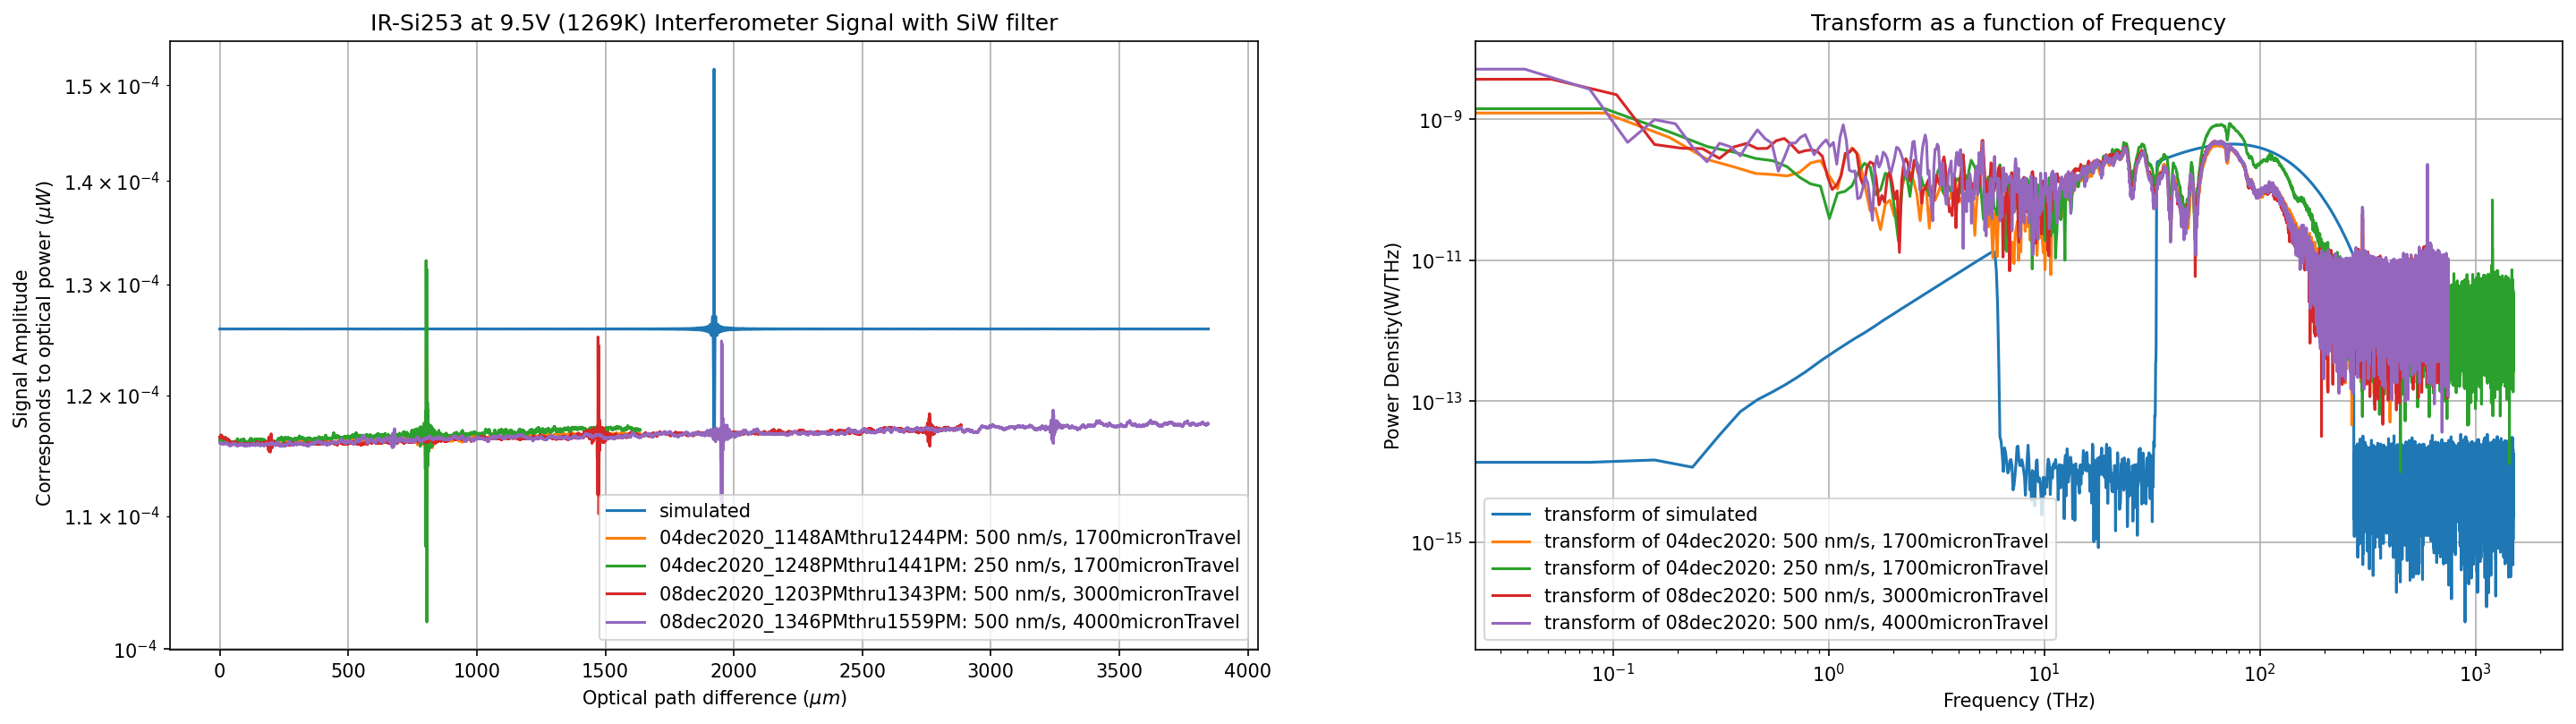

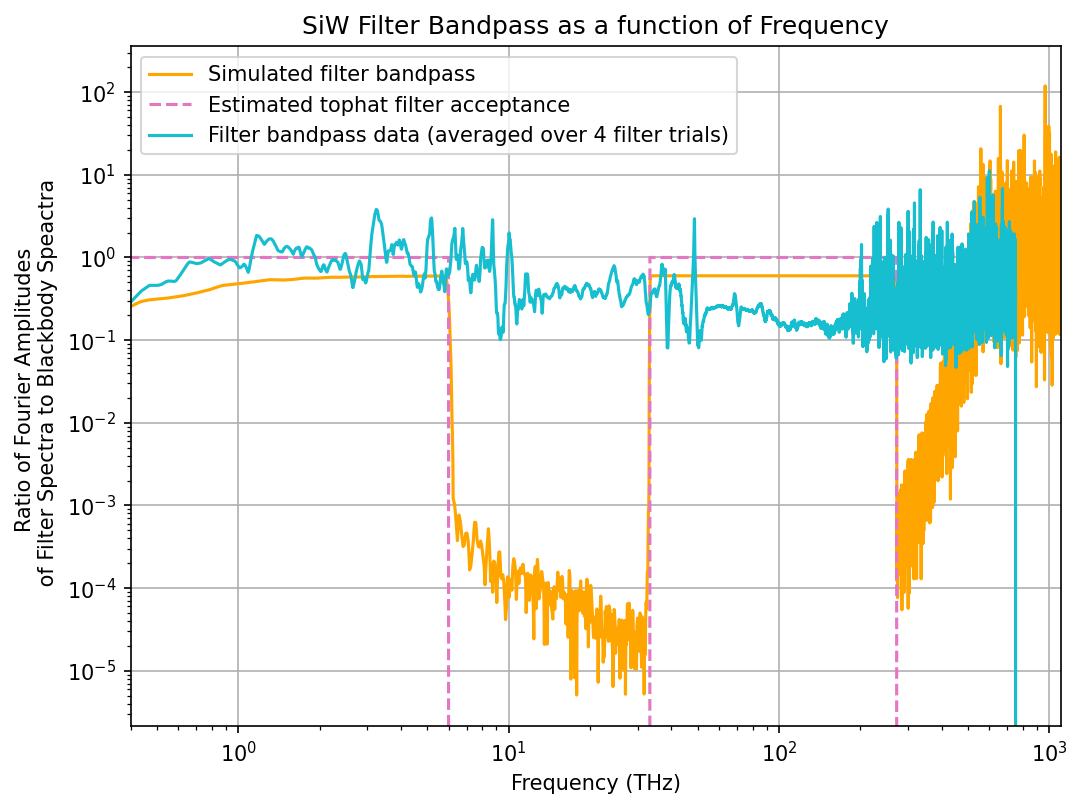

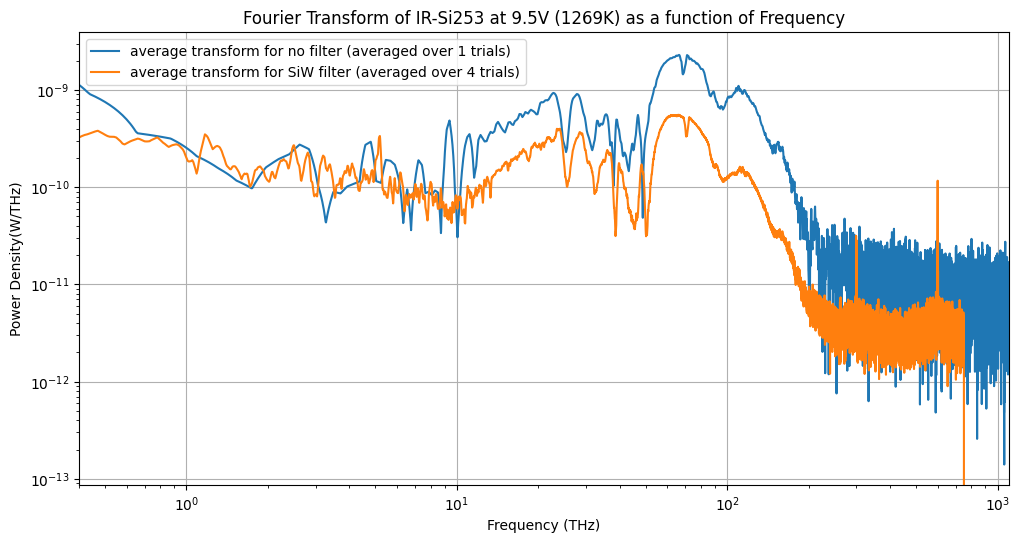

In [514]:
selected_volt = 9.5
source = "IR-Si253"
filt = "SiW"
plot_sim = True
plot_data(selected_volt, source, filt, plot_simulation = plot_sim, bandpass = True, scale_weight = 3e-3, add_weight = 1e-4)

Plot with Plastic Bag Filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


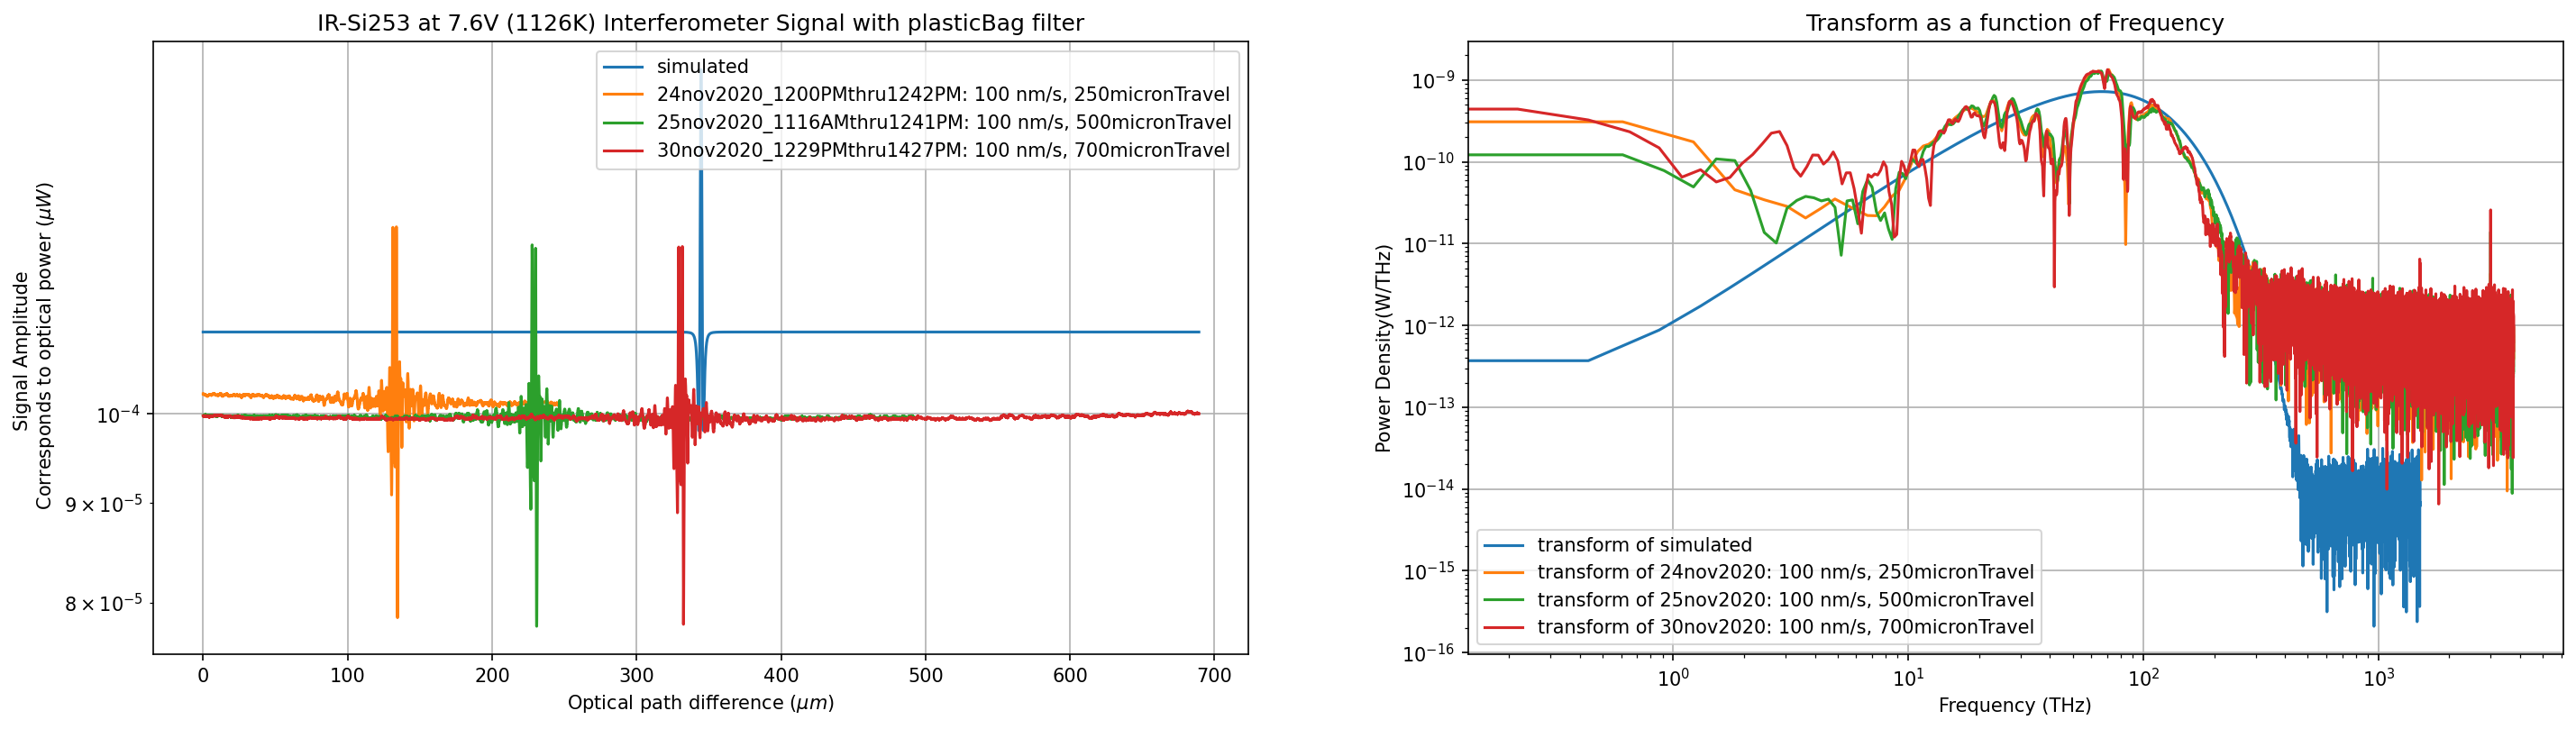

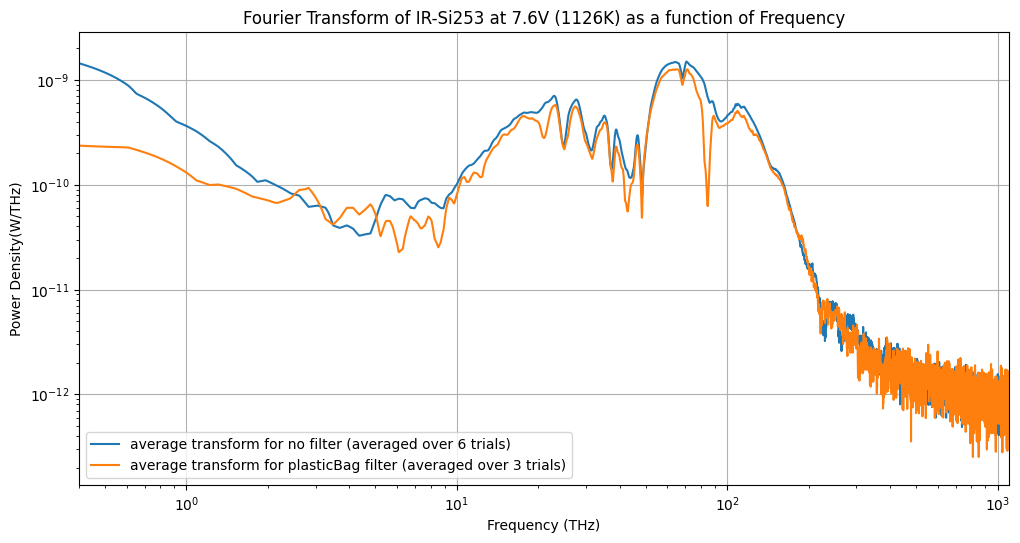

In [515]:
selected_volt = 7.6
temp = get_temp(selected_volt)
source = "IR-Si253"
filt = "plasticBag"
plot_sim = True

plot_data(selected_volt,source, filt, plot_simulation = plot_sim, scale_weight = 7e-3, add_weight = 7e-5)

Plot Double Plastic Bag Filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


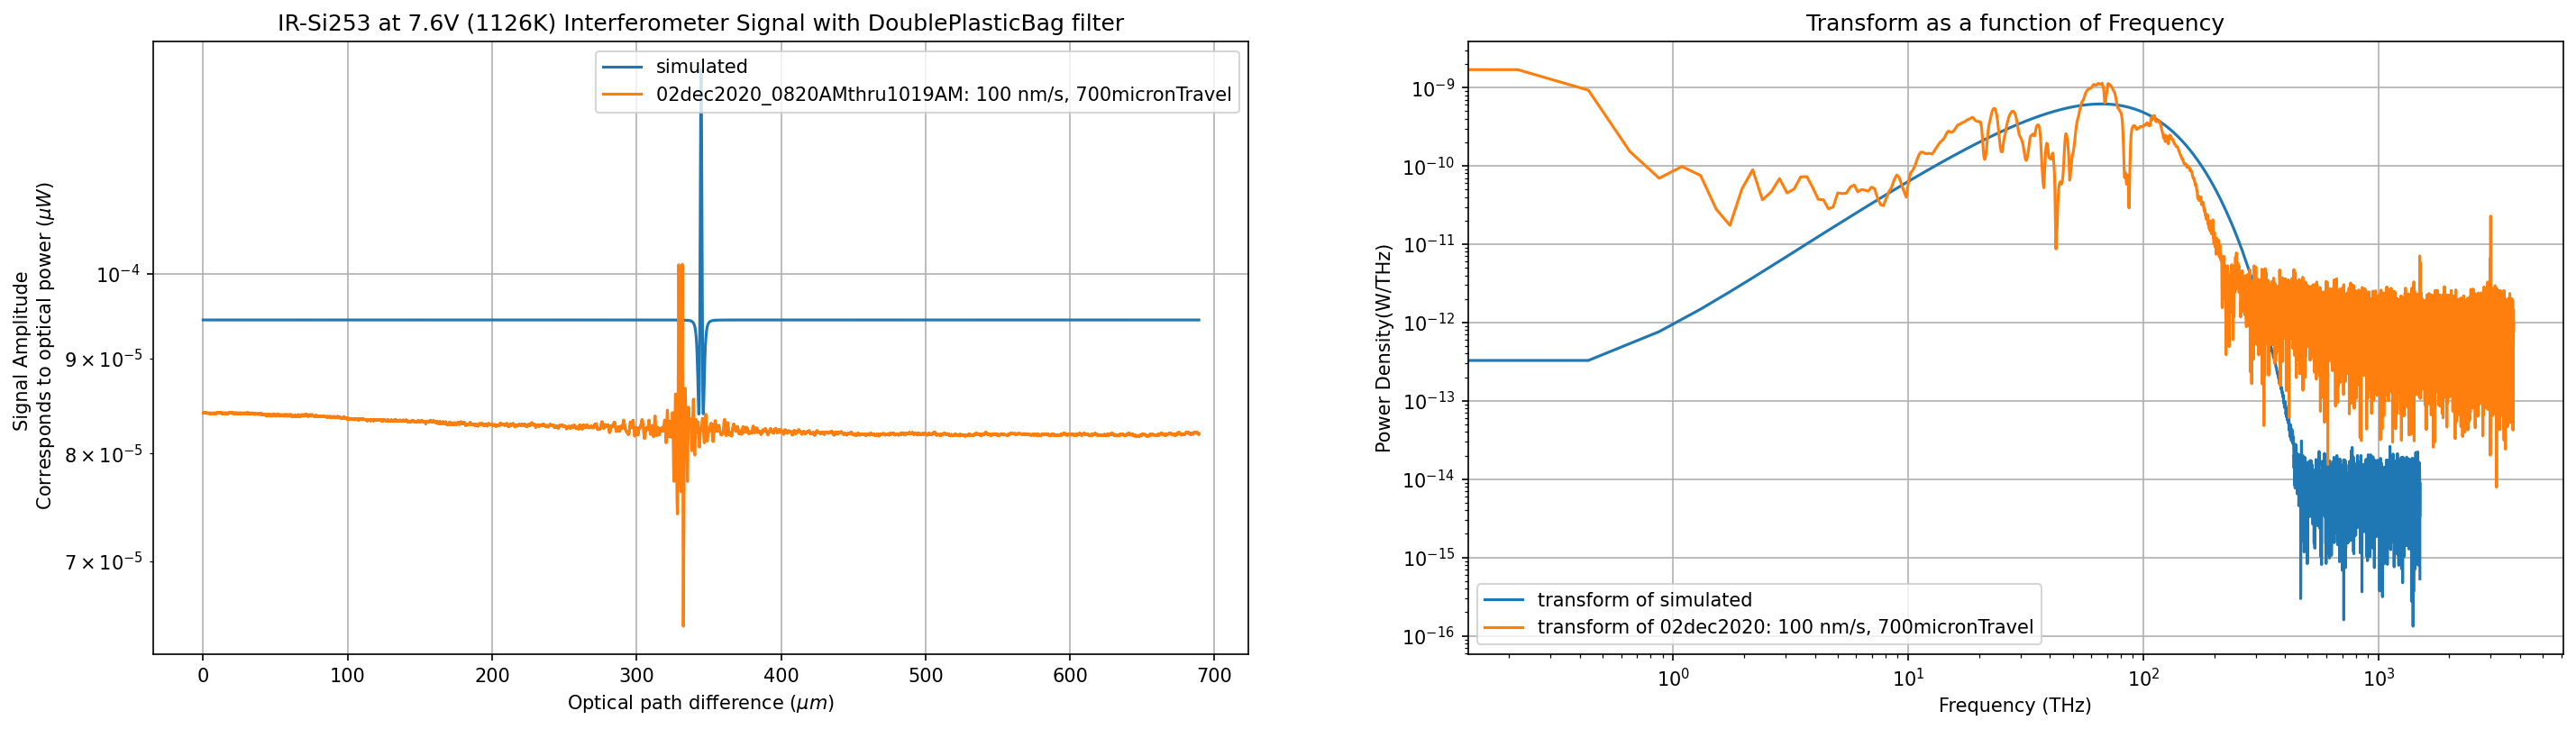

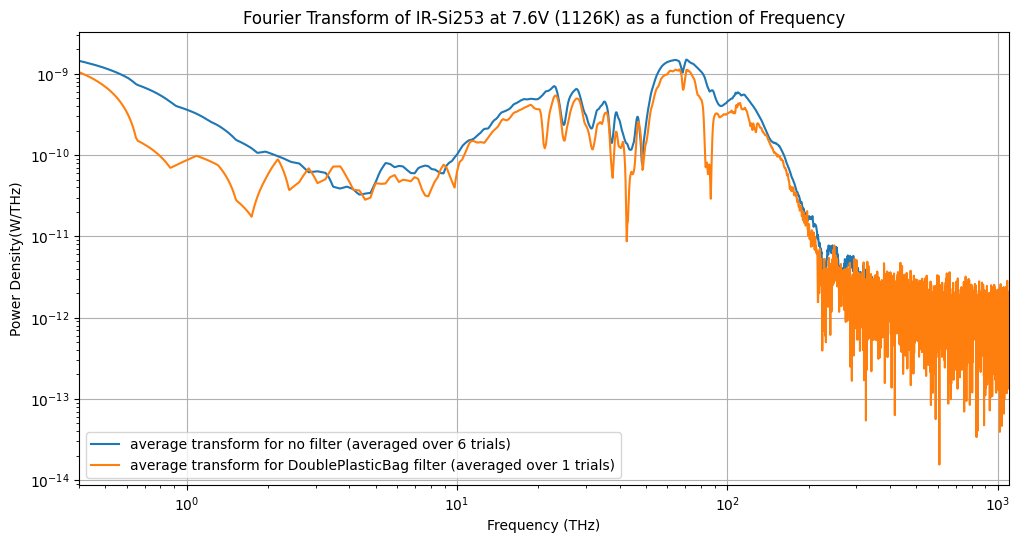

In [516]:
selected_volt = 7.6
source = "IR-Si253"
filt = "DoublePlasticBag"
plot_sim = True

plot_data(selected_volt, source, filt, plot_simulation = plot_sim, scale_weight = 6e-3, add_weight = 6e-5)

Plot 1650nm banpass filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


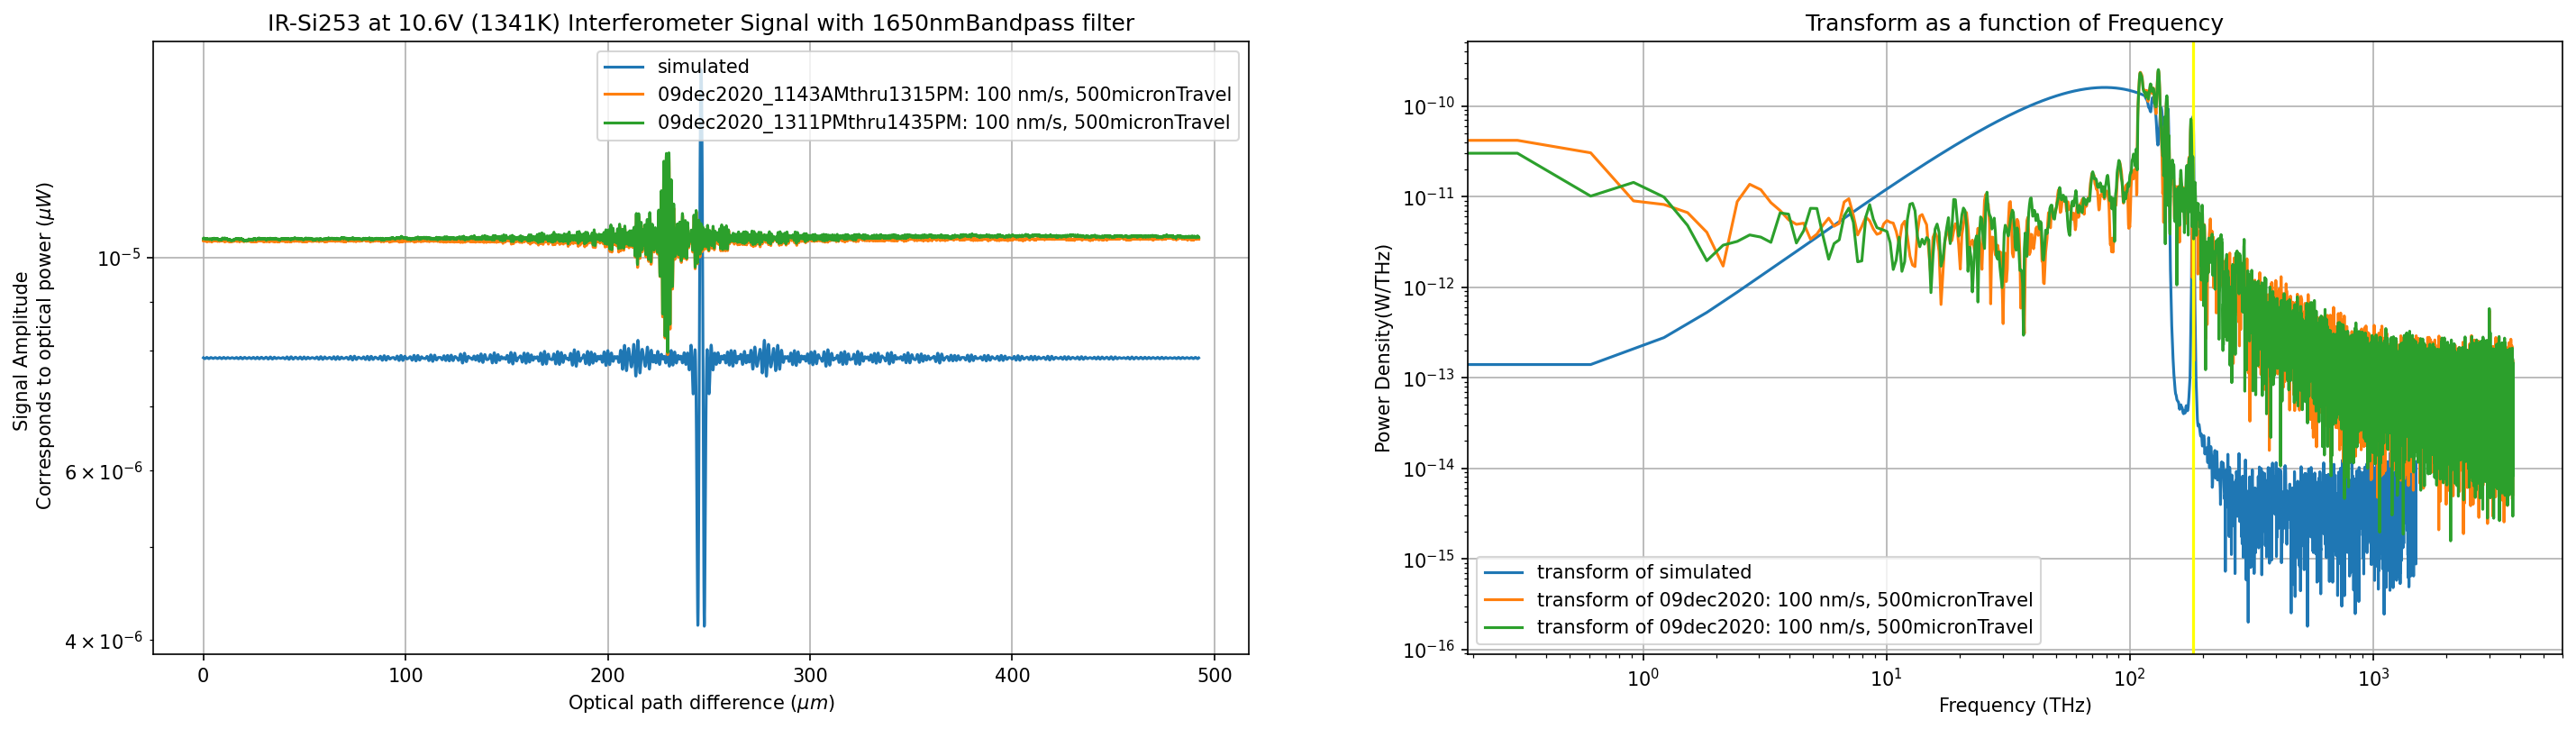

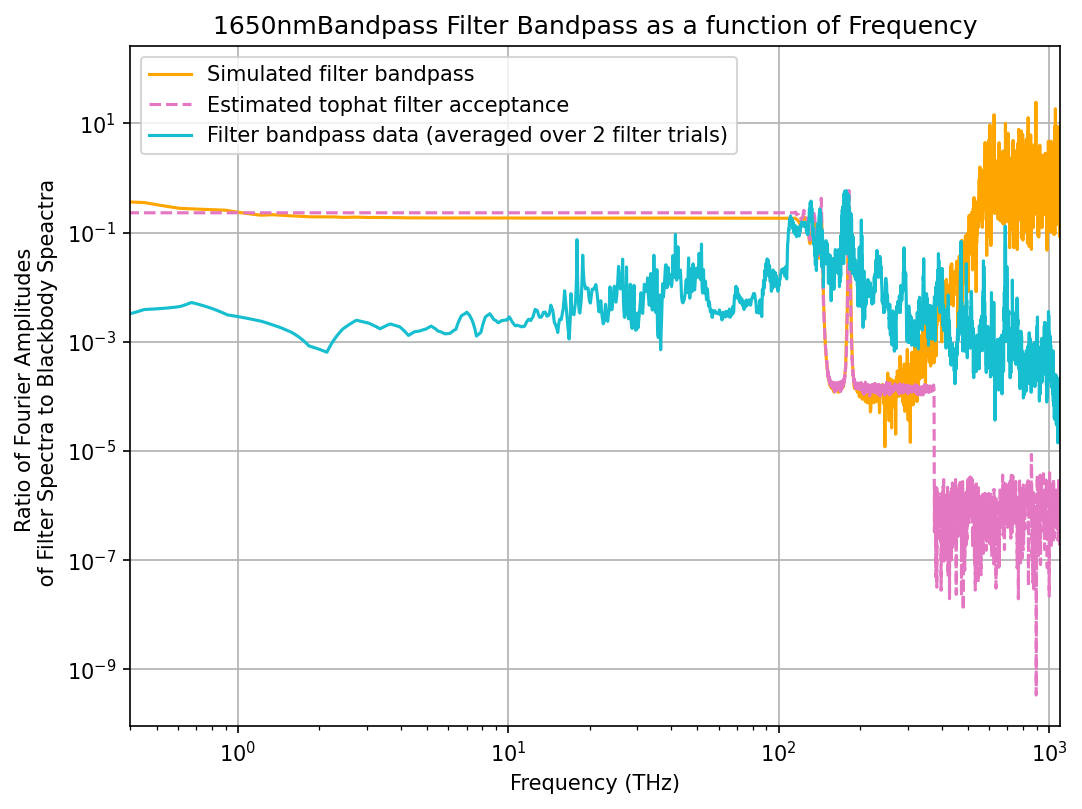

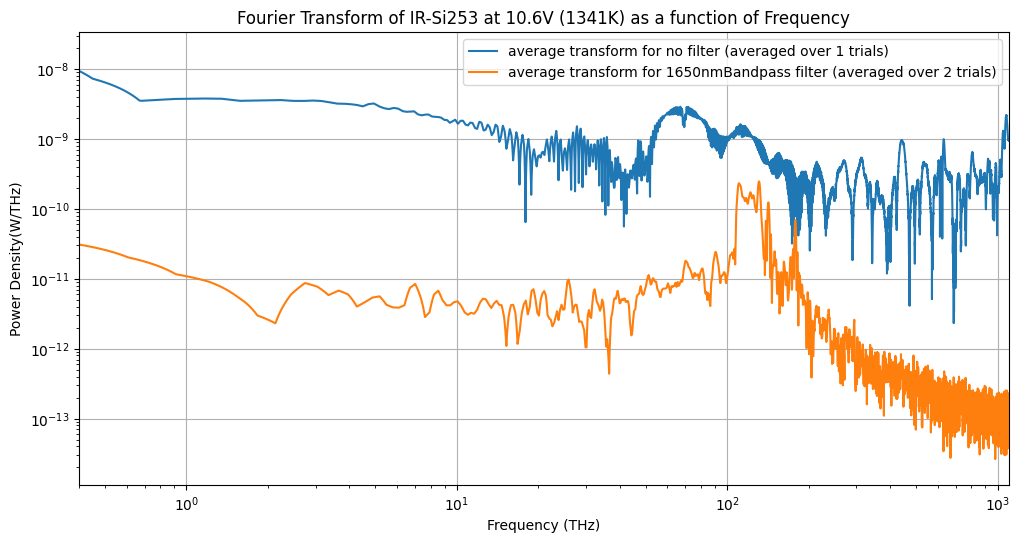

In [522]:
selected_volt = 10.6
source = "IR-Si253"
filt = "1650nmBandpass"
plot_sim = True

plot_data(selected_volt, source, filt, plot_simulation = True, bandpass = True, scale_weight = 4e-3, add_weight = 1e-8)

Plot 1000nm banpass filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


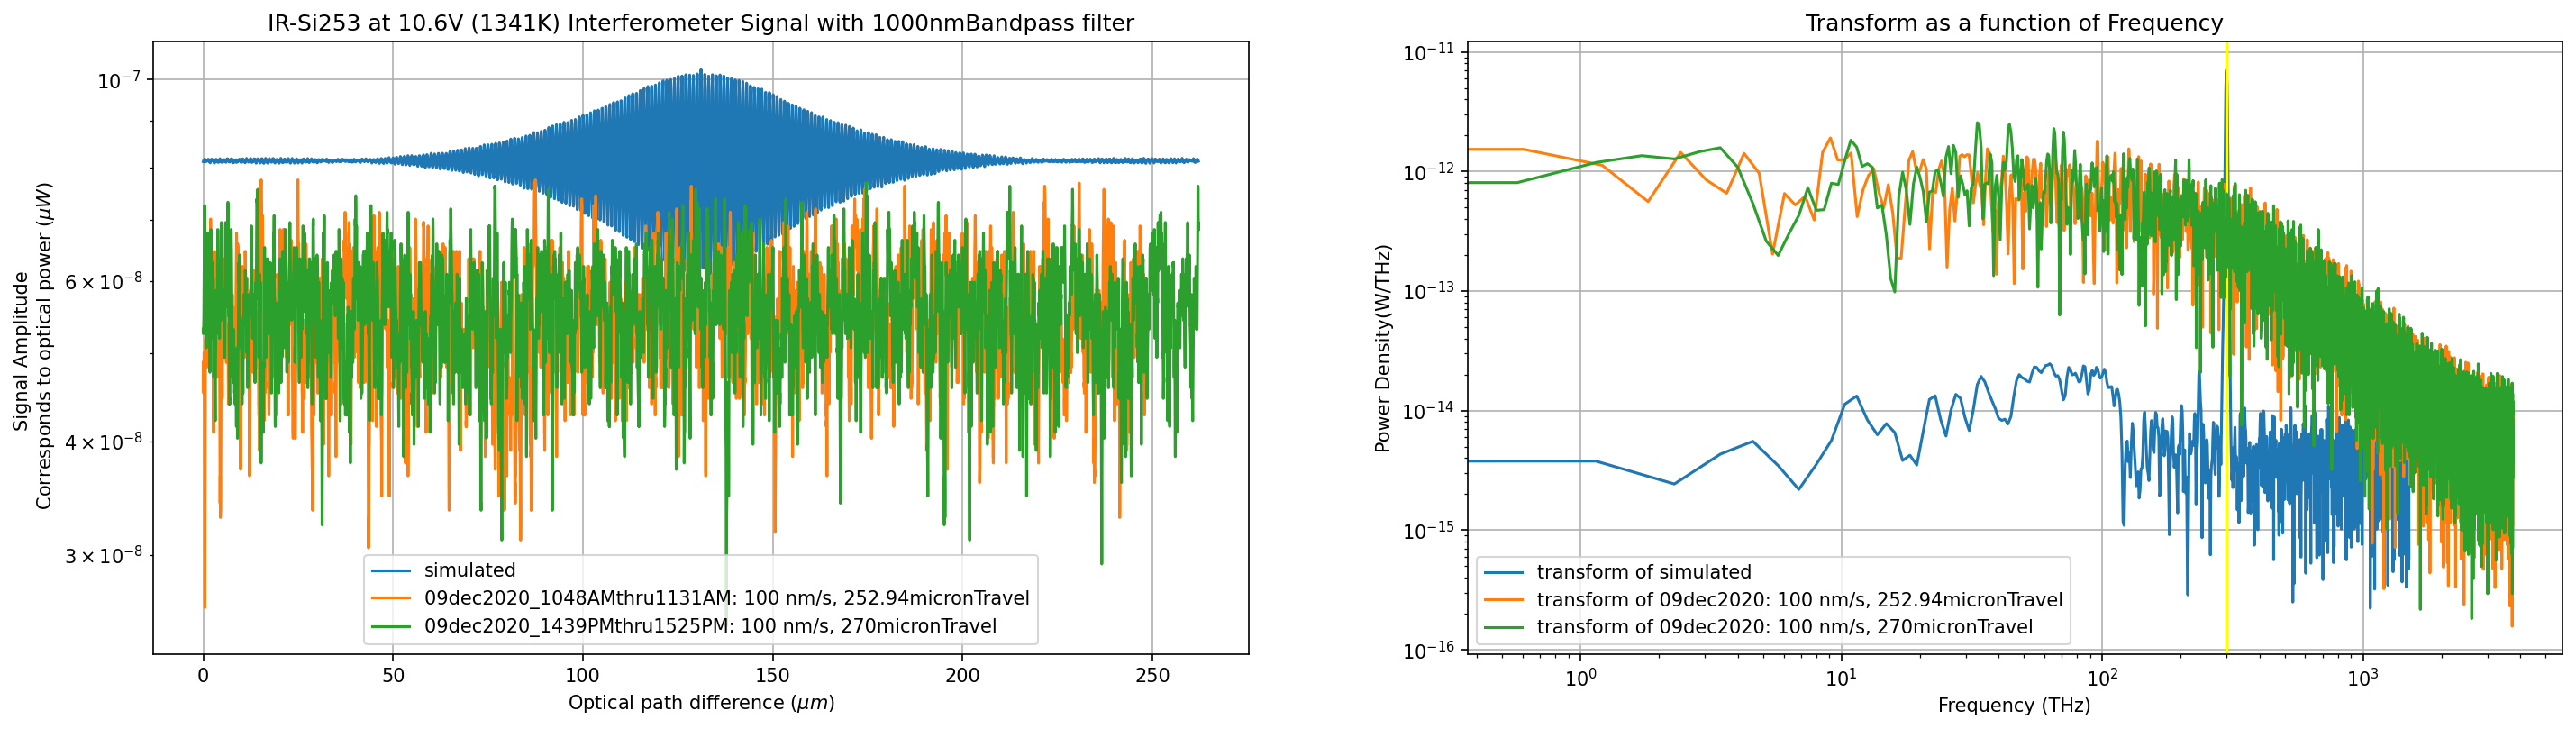

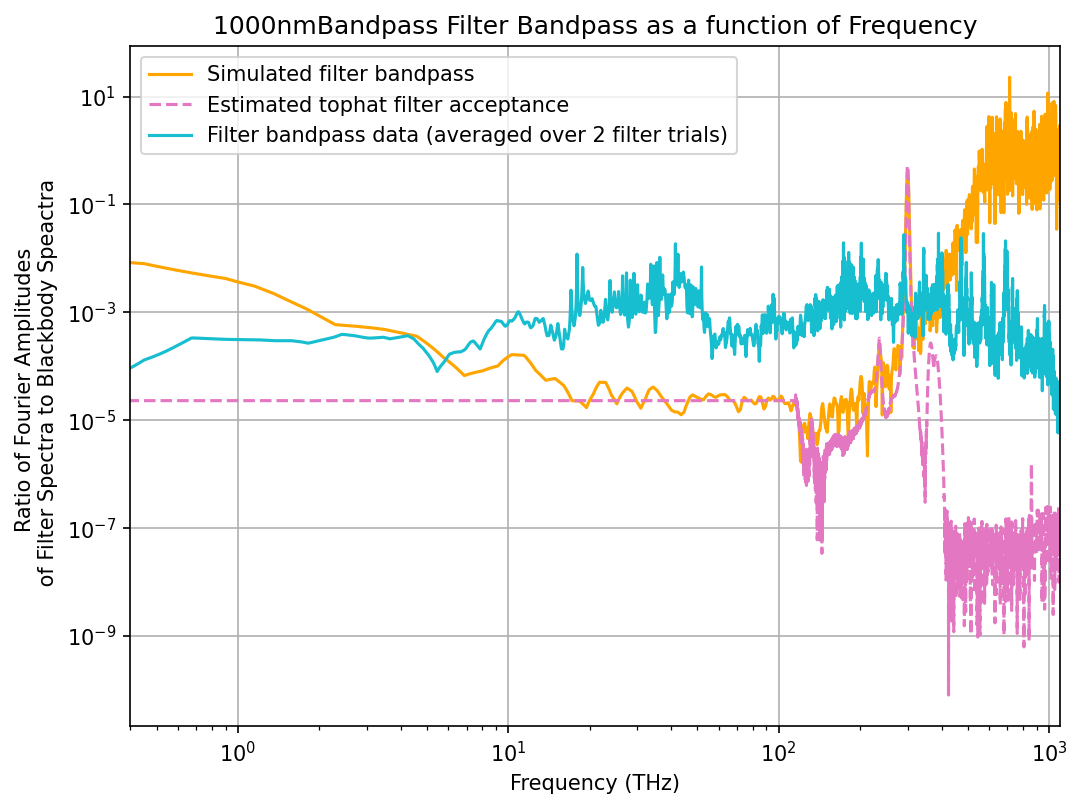

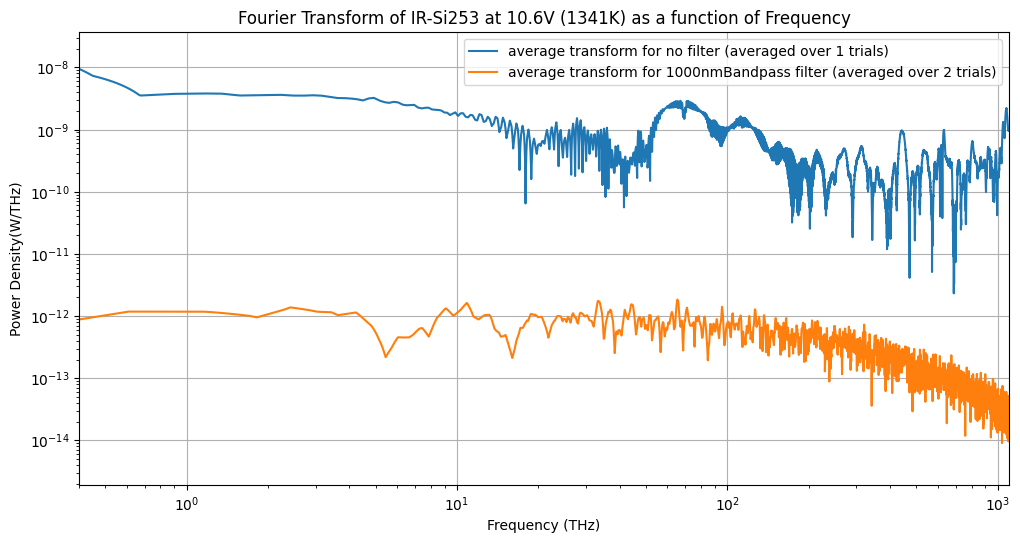

In [521]:
selected_volt = 10.6
source = "IR-Si253"
filt = "1000nmBandpass"
plot_sim = True


plot_data(selected_volt, source, filt, plot_simulation = True, bandpass = True, scale_weight = 5e-3, add_weight = 6e-8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


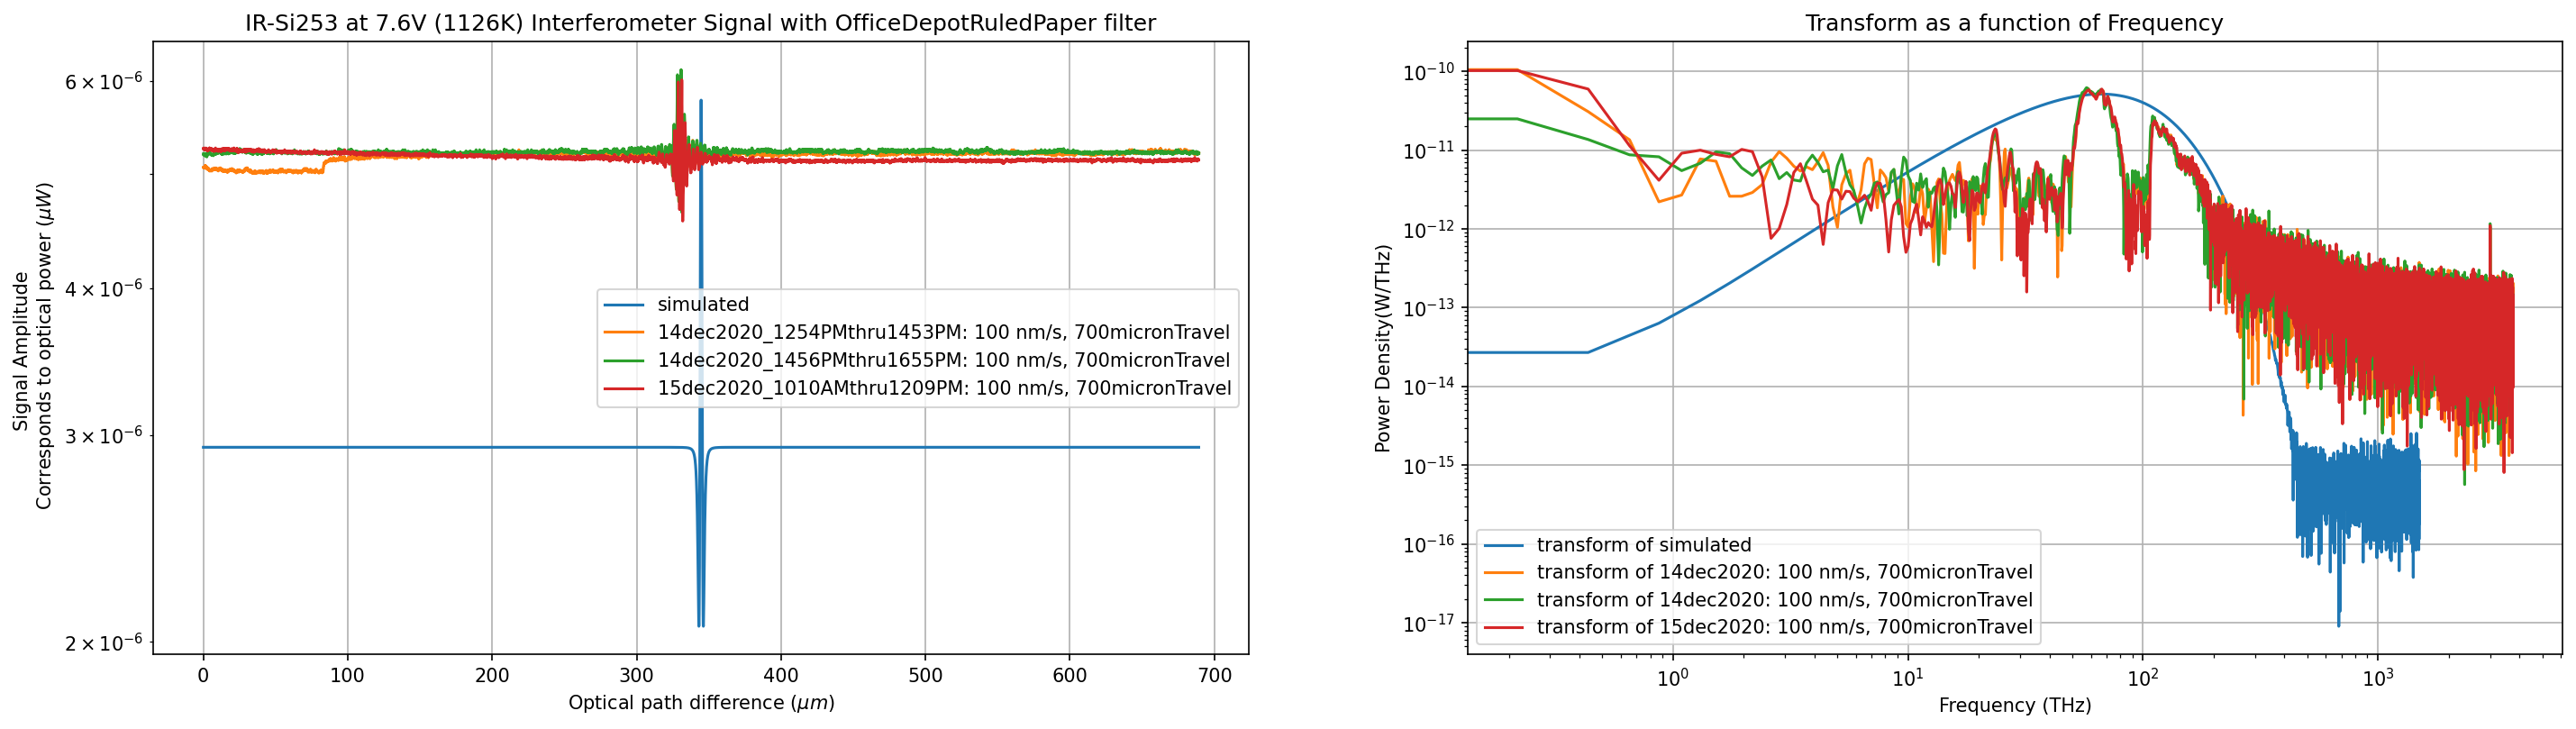

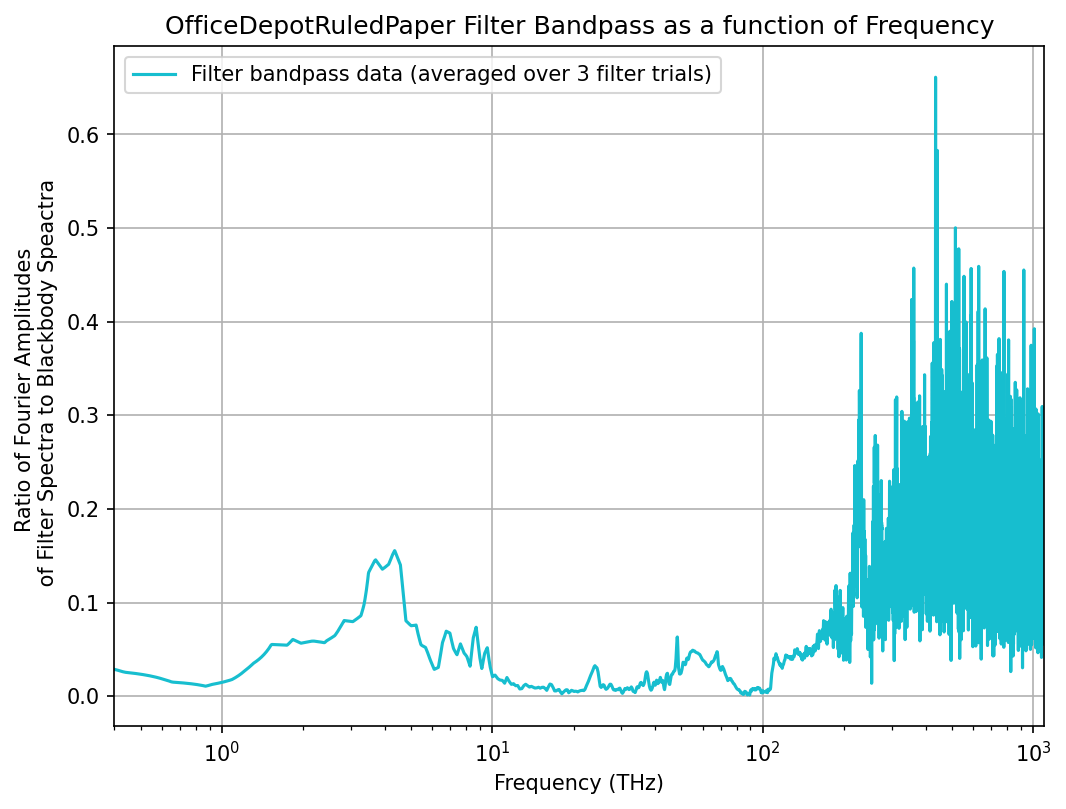

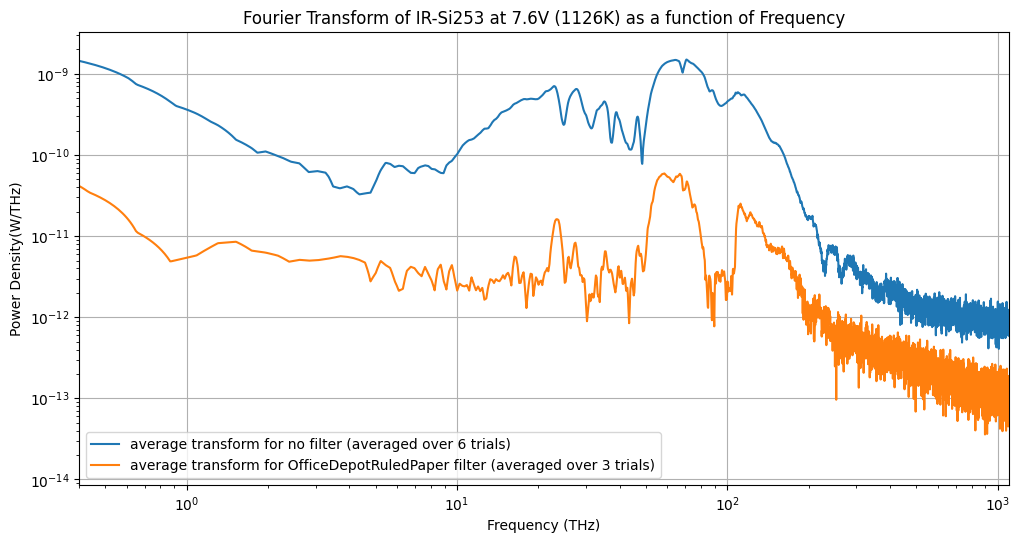

In [520]:
selected_volt = 7.6
source = "IR-Si253"
filt = "OfficeDepotRuledPaper"
plot_sim = True 

plot_data(selected_volt, source, filt, plot_simulation = True, bandpass = True, scale_weight = 5e-4, add_weight = 6e-8)